# A - Introduction à PySpark 
## Introduction
**Apache Spark** est un framework (infrastructure logicielle) open-source de calcul distribué qui permet de traiter des bases de données de taille massive. Ceci est permis grâce à une distribution de données intelligente où les calculs sont effectués en parallèle sur plusieurs clusters, travaillant chacun sur une partie des données.

Si vous avez des bases de données trop volumineuses entraînant des temps de calcul trop lents, il est judicieux d'utiliser Apache Spark.

Spark est un framework optimisé pour le traitement de données et l'application d'algorithmes de Machine Learning. Cela est notamment possible grâce à des structures de données présentées dans ce module.

Apache Spark a été développé par l'AMPLab de UC Berkeley. Il a été développé en Scala et est au meilleur de ses capacités dans son langage natif. La librairie PySpark propose d'utiliser Spark avec le langage Python où dans de nombreux cas d'usages les performances sont similaires à des implémentations avec **Scala**.

Nous allons voir au cours de ce module qu'il est possible de traiter et d'analyser des bases de données grâce au framework Spark et en un temps très court, dès lors que nous avons des clusters à disposition.

Au cours de cette formation, nous allons :

- Présenter les différents éléments centraux de Spark, en commençant par les RDD, la structure la plus élémentaire de Spark qui permet d'effectuer des tâches très variées.
- Comprendre le fonctionnement sous-jacent de Spark.
- Présenter le type DataFrame, une structure plus riche que les RDD, optimisée pour le Machine Learning. La structure DataFrame de Spark est très proche dans sa forme à celle du package pandas en Python. Les DataFrame de Spark offrent néanmoins une performance sans égale lorsqu'ils sont mis en place sur plusieurs clusters.
- Nous terminerons cette formation avec la construction d'un système de recommandation avec Spark qui sera une bonne base pour une mise en production.  

Dans ce chapitre nous allons nous intéresser aux **Resilient Distributed Datasets (RDD)**.

Ce premier exercice a pour but de se familiariser avec les concepts de base de Spark et plus généralement de la distribution de données. La structure RDD est la structure élémentaire de Spark, elle est souple et optimale en performance pour toute opération linéaire. Cette structure a cependant une performance limitée lorsqu'il s'agit d'opérations non linéaires, c'est pour cela que nous introduirons la structure DataFrame dans le chapitre suivant.

Tout au long de cette formation, nous travaillerons sur une base de données proposée par IBM que nous avons mise en forme (version originale disponible ici) contenant tous les vols effectués par Alaska Airlines sur l'année 2008 ainsi que les informations relatives aux annulations et retards des différents vols.

## 1. Introduction au SparkContext
Avant de commencer à coder, il est important de comprendre les bases de fonctionnement de Spark. Toute fonction Spark est appelée à partir d'un SparkContext.

SparkContext est l'objet qui gère les connexions avec le cluster Spark et coordonne les différents calculs sur les différents clusters. Un des très gros avantages de Spark réside dans le fait que nous ne pourrions définir le SparkContext qu'une seule fois, et que le code est totalement indépendant du SparkContext. Si nous travaillons sur un cluster de 8 machines par exemple, la distribution des calculs se fait par le biais du SparkContext, mais le reste du code reste identique. Il est donc possible de développer son code en local ou sur une machine quelconque. Pour envoyer le programme en production sur un **cluster**, il suffira de changer la définition du SparkContext. Par convention, sc désignera le SparkContext tout au long de la formation.

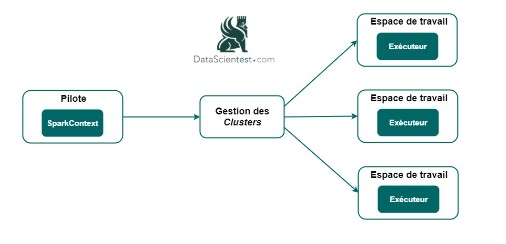

- (a) Exécuter la cellule ci-dessous pour importer SparkContext et définir un SparkContext local.   
   L'exécution deux fois successives de la cellule ci-dessous génère une erreur. En général, il est conseillé d'utiliser SparkContext.getOrCreate() qui récupère un contexte Spark s'il y en a un, ou le crée sinon.

In [ ]:
"""
probleme de version spark et pyspark pour la version python...trouver une solution
Cannot run program "python3": CreateProcess error=2, Le fichier spécifié est introuvable
"""

In [ ]:
import pyspark  # ?? leur version = 2.4.3, ici 3.3.0

In [ ]:
import sys
sys.version  # ok verion python ici = 3.9.12 ( et 3.9.13 sur spyder-env )

In [ ]:
# Import de SparkContext du module pyspark
from pyspark import SparkContext

# Définiton d'un SparkContext en local
sc = SparkContext('local')
                          

In [ ]:
sc

Un RDD est la représentation Spark d'un tableau de données, c'est une collection d'éléments que l'on peut utiliser pour contenir des tuples, des dictionnaires, des listes, etc. La structure RDD ressemble à une liste Python mais elle est distribuée sur plusieurs clusters et sa vitesse d'exécution est optimisée pour l'ensemble des opérations linéaires.

Nous insistons sur l'avantage des programmes Spark à être identique pour travailler en local ou sur plusieurs clusters. Localement, Spark simule une distribution des calculs en divisant la mémoire de l'ordinateur sans qu'aucune modification du code soit nécessaire : il est possible de développer sur sa machine puis de mettre en production ce code sur un cluster en ne modifiant que le SparkContext.

La méthode textFile d'un SparkContext permet de charger un fichier CSV (ou un fichier compressé) dans un RDD. Cette fonction s'utilise ainsi :

sc.textFile("path_to_file.ext")   

- (b) Importer la base de données "2008_raw.csv" dans un RDD appelé raw_rdd

In [ ]:
# Importer la bibliothèque time et calcul du temps au début de l'exécution (t0)
from time import time
t0 = time()

#Lecture du fichier "2008_raw.csv"
raw_rdd = sc.textFile("raw_2008.csv")
# lien de la data
# https://raw.githubusercontent.com/nraychaudhuri/ibm-spark-examples/master/data/airline-flights/alaska-airlines/2008.csv

### Ne pas modifier le code ci-dessous
# Calcul du temps de la lecture du fichier
t1 = time() - t0
print("Réalisé en {} secondes".format(round(t1,3)))

In [ ]:
import pandas as pd
df = pd.read_csv("raw_2008.csv")
df.info()    # PB eux 18 colonnes seulement, moi 29 colonnes !!! meme nombre de lignes

    - Une caractéristique importante des RDD est leur immutabilité. Une fois créés, ils ne peuvent plus être modifiés. Il faudra donc créer un nouveau RDD chaque fois que l'on voudra le modifier: une opération à éviter au maximum pour préserver la mémoire de l'ordinateur ou du serveur. Ce caractère immutable est essentiel pour le fonctionnement du calcul distribué : il garantit qu'une fois le RDD distribué sur un cluster, aucune modification n'aura lieu sur une partie du RDD qui pourrait fausser les résultats finaux.
## 2. Évaluation Paresseuse
L'appel à la fonction a été exécuté en un temps bref. Cela est lié au second avantage de cette structure qui est leur capacité à évaluer le code de façon paresseuse (lazy evaluation), c'est à dire reporter le lancement des calculs jusqu'à ce que ce soit absolument nécessaire.

Par exemple, lorsque la méthode sc.textFile a été appelée, seul un pointeur vers le fichier a été créé. Ce n'est qu'au dernier moment, lorsque l'on recherche à afficher ou utiliser un résultat, que le calcul est effectué.

Pour apercevoir le contenu d'un RDD, on doit utiliser des méthodes comme take(n) permet de retourner les n premiers éléments d'un RDD. Toutes les méthodes PySpark sont ici très puissantes. En effet, PySpark est une bibliothèque qui interface avec Python en cachant le langage Scala. Par exemple, la méthode take renvoie une liste Python d'éléments mais est allée chercher cette information au sein d'un cluster Spark codé en Scala.

La force de PySpark réside dans l'exploitation des performances de l'architecture de Spark sans coder une seule ligne de Scala.

- (a) Afficher les 5 premiers éléments de raw_rdd à l'aide de la méthode take.
- (b) Mesurer le temps nécessaire à l'affichage de ces 5 éléments.

In [ ]:
# Calcul du temps au début de l'exécution (t0)
t0 = time()

# Affichage de 5 éléments du rdd
print(raw_rdd.take(5))

# Calcul du temps de l'affichage des 5 éléments
t1 = time() - t0
print("Réalisé en {} secondes".format(round(t1,3)))


In [ ]:
"""
Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 0.0 failed 1 times, most recent failure: Lost task 0.0 in stage 0.0 (TID 0) (HappyNous executor driver): 
java.io.IOException: Cannot run program "python3": CreateProcess error=2, Le fichier spécifié est introuvable
"""

    - Le temps de calcul pour charger 5 lignes est donc plus grand que celui de la méthode textFile. En effet, textFile construit simplement un pointeur vers la donnée alors que take(5) calcule les résultats pour les 5 premières lignes. Vous êtes invité à faire varier le nombre de lignes pour tester le temps de calcul de votre ordinateur : testez avec 10, 100, 1000, etc.  
    
    - Vous pouvez remarquer que les colonnes d'un RDD ne sont pas "nommées". Les RDD sont extrêmement rapides pour le traitement des données en ligne mais ne possèdent pas de structure inhérente permettant de faire des traitements en colonne.  
    
La méthode count qui permet de compter le nombre de lignes du RDD demande d'aller chercher les informations au sein du fichier CSV et donc demande un léger temps de calcul.

- (c) Utiliser la méthode count pour enregistrer dans une variable nommée count le nombre de lignes du RDD

In [ ]:
# Calcul du temps au début de l'exécution (t0)
t0 = time()

# Insérez votre code ici



### Ne pas modifier le code ci-dessous
# Calcul du temps d'affichage du nombre de lignes du RDD
t1 = time() - t0
print("Nombre de lignes :", count)
print("Réalisé en {} secondes".format(round(t1,3)))

## 3. Map & Reduce
Un RDD lit un fichier ligne par ligne. Dans son format actuel, il permet d'afficher certaines lignes ou de compter le nombre de lignes. Chaque ligne est un simple string contenant l'ensemble des données séparées par des virgules. Il faut donc séparer chaque ligne en une liste d'éléments pour pouvoir les traiter séparément par la suite.

Pour effectuer des traitements sur les lignes d'un RDD, il est possible d'utiliser la méthode map qui prend en argument une fonction à appliquer sur chaque ligne. N'importe quelle fonction peut être mise en argument dans map, à partir du moment où elle prend une ligne en entrée et renvoie en sortie une ligne à stocker dans un nouveau RDD.



Exemple : Renvoyer le premier élément de chaque ligne
-     raw_rdd.map(lambda line: line[0])   


Fonctions anonymes

Le mot clé lambda permet de créer une fonction en une seule ligne. Par exemple, il existe deux façons de créer la fonction fun : 

• def fun(x):   
    return x[0]   
• fun = lambda x: x[0]   

Cette écriture a l'avantage de pouvoir être écrite directement au sein du code, sans avoir besoin de créer la fonction fun pour l'utiliser. Le même résultat est obtenu en créant une fonction fun puis en l'appelant dans map : raw_rdd.map(fun)

- (a) Créer un RDD nommé airplane_rdd dont chaque ligne est la liste des éléments de la ligne correspondante de raw_rdd.
- (b) Afficher la première ligne de ce nouveau RDD.   
    -  La méthode split permet de transformer une chaîne de caractères en une liste. Par exemple, la fonction qui a une chaîne de caractère line associe la liste line.split(",") isole tous les éléments de la ligne originellement séparés par des virgules.

In [ ]:
# Création d'un RDD dont les lignes sont la liste des éléments de raw_rdd 
airplane_rdd = raw_rdd.map(lambda line: line.split(","))

# Affichage de la première ligne du rdd
airplane_rdd.take(1)

Les RDD fonctionnent très bien pour des opérations "ligne par ligne", c'est pour cela que les méthodes map et reduce sont extrêmement efficaces pour ces calculs. Appliquer successivement la méthode map puis la méthode reduceByKey permet de résumer intelligemment nos données.

Par exemple, pour construire un diagramme à barres du nombre de vols effectués par aéroport de départ (l'aéroport de départ est la 8ème variable), il faut procéder en plusieurs étapes :

- (c) Utiliser la méthode map pour regrouper les données dans un couple grâce à la fonction qui à line associe le couple (line[7], 1). Cela nous permet d'avoir pour chaque ligne :
    - Une clé correspondant à l'aéroport de départ.
    - Une valeur égale à 1 (à additionner ultérieurement).    
    
reduceByKey(f) combine des couples ayant la même clé en leur appliquant une fonction f. Il est donc possible ici d'appliquer la fonction f qui à un couple (x,y) associe x+y de façon à additionner successivement toutes les valeurs et donc obtenir le nombre d'apparition de chaque clé.    
   
- (d) Créer un RDD nommé hist_rdd, en appliquant à airplane_rdd la méthode map puis la méthode reduceByKey comme expliqué ci-dessus.
- (e) Afficher les 5 premières lignes de hist_rdd.

In [ ]:
# Création d'un nouveau RDD en résumant les lignes par aéroport de départ
hist_rdd = airplane_rdd.map(lambda x: (x[7], 1)).reduceByKey(lambda x,y: x+y)

# Affichage d'un 5 premières lignes 
hist_rdd.take(5)


     - De façon plus générale, les techniques de map et reduce permettent de résumer les données et s'effectuent généralement de la façon suivante :   
     
• Créer un couple (key, value) sur chaque ligne grâce à map.   
• Regrouper les clés grâce à reduceByKey en effectuant l'opération de notre choix sur les valeurs.   

## 4. La méthode collect pour forcer l'évaluation 
Les évaluations précédentes ont prouvé que les RDD sont évalués paresseusement. La méthode collect offre la possibilité de forcer son calcul. Cette méthode est très pratique pour afficher des RDD de petite taille, notamment ceux issus d'un map ou reduce.

     - La méthode collect prend en entrée un RDD et renvoie une liste correspondante au contenu du RDD. Le résultat de cette fonction se traite donc comme une liste et ne possède plus les attributs d'un RDD. Il est notamment non distribué et ne bénéficie plus de l'architecture de Spark.
- (a) Créer puis afficher la liste hist à partir du RDD hist_rdd.

In [ ]:
# Création d'une liste à partir d'un RDD
hist = hist_rdd.collect()

# Affichage de la liste 
print(hist)

## 5. Trier et filtrer un RDD 
Beaucoup d'aéroports sont présents dans la liste ce qui la rend peu lisible au premier coup d'œil. Il est donc intéressant de trier cette liste par rapport aux valeurs de chaque clé (i.e.le nombre de vol pour chaque aéroport).

Pour cela, il est possible d'utiliser la fonction sorted qui prend en paramètre :

- list : la liste à trier.
- key : la liste des éléments à utiliser par référence de tri.
- reverse : un entier indiquant l'ordre du tri : croissant (reverse = 0) ou décroissant (reverse = 1).  

Exemple : Tri par ordre alphabétique sur le premier élément   
sorted(hist_rdd.collect(), key=lambda x: x[0])   

- (a) Afficher hist_rdd ordonné de façon décroissante par rapport au nombre de vol par aéroport.

In [ ]:
# Tri des données par ordre décroissant
sorted(hist, key= lambda x: x[1], reverse= 1)

D'après le tri, l'aéroport de Seattle est de loin l'aéroport le plus desservi.

Il est souvent intéressant de pouvoir filtrer nos données. En effet, les fichiers CSV possèdent un header contenant le nom de la variable qui va être interprétée comme une modalité. Il existe pour cela la méthode filter qui permet filtrer certaines lignes.

Exemple : Modalité de la première colonne
airport_rdd.filter(lambda x: x[0] == "year")   

- (b) Afficher le nombre de vols annulés par ville d'origine. Pour cela :
    - Filtrer les vols annulés ( line[10] ) à l'aide de filter.
    - Effectuer un map et reduce pour compter le nombre d'occurrence par ville d'origine (line[8]).
    - Afficher les résultats.

In [ ]:
# Calcul et affichage du nombre de vols annulés par ville d'origine
airplane_rdd \
    .filter(lambda x: x[10] == "1") \
    .map(lambda x: (x[8], 1)) \
    .reduceByKey(lambda x,y: x+y) \
    .collect()

- Il est possible d'écrire le code en une seule ligne. L'utilisation du "\" permet de passer à la ligne entre chaque méthode. En effet, comme chaque méthode PySpark utilisée ici crée un nouvel objet, il est alors optimal d'effectuer toutes les opérations successivement. L'utilisation de "\" permet donc un code plus lisible. Par exemple : 
     -  rdd \
        -  .filter(fun1) \
        - .map(fun2) \
        - .reduceByKey(fun3) \
        - .collect()    
        
Une fois que toutes les opérations sont effectuées et terminées, il faut avoir le bon réflexe de fermer le SparkContext ouvert en début d'exercice. En effet, on ne peut pas avoir plus d'un contexte sur une machine et pour éviter les conflits à l'avenir, fermer son SparkContext permet de s'assurer que plus aucun programme ne tourne sur la machine. Pour cela il existe tout simplement la méthode stop sans paramètre.

- (c) Fermer sc, le SparkContext de l'exercice.

In [67]:
# Fermeture du SparkContext
sc.stop()

# B - Data Processing 
Introduction
La structure RDD que nous avons étudiée est importante. Cependant, lorsqu'il s'agit de gérer des bases de données structurées (organisées en colonnes), nous verrons qu'il existe une structure plus optimale. Les RDDs sont néanmoins extrêmement performants devant un problème non structuré tel qu'un texte.

Dans cet exercice, nous allons utiliser la structure RDD pour une base de données non structurée : l'intégrale des Misérables de Victor Hugo. L'objectif est de construire un simple WordCount comptant le nombre d'occurrences de chaque mot, pour approfondir et mettre en pratique vos compétences en RDD et map reduce.

Pour cet exercice, nous considérons un fichier texte contenant l'intégralité des Misérables de Victor Hugo.

## 1. Création d'un SparkContext
(a) Exécuter la cellule ci-dessous pour importer SparkContext et définir un SparkContext local nommé sc.

In [ ]:
# Import de SparkContext du module pyspark
from pyspark import SparkContext

# Défintion d'un SparkContext
sc = SparkContext.getOrCreate()

## 2. Importation de la base de données

- (a) Importer le fichier miserables_full.txt dans un RDD nommé miserables.
- (b) Afficher les 10 premières lignes du RDD.

In [ ]:
# Chargement du fichier "miserables_full.txt" et affichage des 10 premières lignes
miserables = sc.textFile("miserables_full.txt")
miserables.take(10)

In [ ]:
""" ->
['Les Misérables Tome 1 - Fantine',
 'Livre Premier - Un Juste',
 'Chapitre I - Monsieur Myriel',
 'En 1815, M. Charles-François-Bienvenu Myriel était évêque de Digne. C’était un vieillard d’environ soixante-quinze ans ; il occupait le siège de Digne depuis 1806.',
 'Quoique ce détail ne touche en aucune manière au fond même de ce que nous avons à raconter, il n’est peut-être pas inutile, ne fût-ce que pour être exact en tout, d’indiquer ici les bruits et les propos qui avaient couru sur son compte au moment où il était arrivé dans le diocèse. Vrai ou faux, ce qu’on dit des hommes tient souvent autant de place dans leur vie et surtout dans leur destinée que ce qu’ils font. M. Myriel était fils d’un conseiller au parlement d’Aix ; noblesse de robe. On contait de lui que son père, le réservant pour hériter de sa charge, l’avait marié de fort bonne heure, à dix-huit ou vingt ans, suivant un usage assez répandu dans les familles parlementaires. Charles Myriel, nonobstant ce mariage, avait, disait-on, beaucoup fait parler de lui. Il était bien fait de sa personne, quoique d’assez petite taille, élégant, gracieux, spirituel ; toute la première partie de sa vie avait été donnée au monde et aux galanteries. La révolution survint, les événements se précipitèrent, les familles parlementaires décimées, chassées, traquées, se dispersèrent. M. Charles Myriel, dès les premiers jours de la révolution, émigra en Italie. Sa femme y mourut d’une maladie de poitrine dont elle était atteinte depuis longtemps. Ils n’avaient point d’enfants. Que se passa-t-il ensuite dans la destinée de M. Myriel ? L’écroulement de l’ancienne société française, la chute de sa propre famille, les tragiques spectacles de 93, plus effrayants encore peut-être pour les émigrés qui les voyaient de loin avec le grossissement de l’épouvante, firent-ils germer en lui des idées de renoncement et de solitude ?',
 'Fut-il, au milieu d’une de ces distractions et de ces affections qui occupaient sa vie, subitement atteint d’un de ces coups mystérieux et terribles qui viennent quelquefois renverser, en le frappant au cœur, l’homme que les catastrophes publiques n’ébranleraient pas en le frappant dans son existence et dans sa fortune ? Nul n’aurait pu le dire ; tout ce qu’on savait, c’est que, lorsqu’il revint d’Italie, il était prêtre.',
 'En 1804, M. Myriel était curé de Brignolles. Il était déjà vieux, et vivait dans une retraite profonde.',
 'Vers l’époque du couronnement, une petite affaire de sa cure, on ne sait plus trop quoi, l’amena à Paris. Entre autres personnes puissantes, il alla solliciter pour ses paroissiens M. le cardinal Fesch. Un jour que l’empereur était venu faire visite à son oncle, le digne curé, qui attendait dans l’antichambre, se trouva sur le passage de sa majesté. Napoléon, se voyant regardé avec une certaine curiosité par ce vieillard, se retourna, et dit brusquement :',
 '— Quel est ce bonhomme qui me regarde ?',
 '— Sire, dit M. Myriel, vous regardez un bonhomme, et moi je regarde un grand homme. Chacun de nous peut profiter.']
 """

3. Mise en forme de la base

Pour compter le nombre d'occurrences d'un mot, il faut mettre tous les mots en forme de la même façon :

    - Mettre toutes les lettres en minuscule grâce à la méthode lower des chaînes des caractères.
    - Remplacer la ponctuation collée aux mots ( .  ,  -  ' ) par des espaces grâce à la méthode replace des chaînes de caractères, qui s'applique de la façon suivante :
    str.replace(',', ' ')
    
- (a) Créer un RDD nommé miserables_clean, qui contient le texte des Misérables en minuscule et sans ponctuation à l'aide des méthodes map, lower et replace.

In [ ]:
# Création d'un RDD nettoyé
miserables_clean = miserables.map(lambda x : x.lower().replace(',', ' ').replace('.', ' ').replace('-', ' ').replace('’', ' '))

Maintenant que tous les mots sont bien séparés par des espaces, il est possible utiliser la méthode split pour séparer les mots de chaque ligne.

Il est possible d'utiliser la méthode map mais le problème ici sera que map crée une liste de listes.

En effet, un split transforme chaque ligne en liste et la base de données étant une liste de lignes, le résultat final sera une liste de listes. Dans ce cas, il est coûteux de comparer un même mot sur deux lignes différentes car ils sont tous les deux dans des listes différentes.

Pour pallier ce problème, il existe une méthode flatMap, qui s'utilise exactement de la même façon que map, à la différence que le résultat final est un RDD à une seule dimension.

- (b) Créer un RDD nommé miserables_flat qui contient l'ensemble des mots sous une seule dimension.

In [ ]:
""" ->
['les', 'misérables', 'tome', '1', '', '', 'fantine', 'livre', 'premier', '']
"""

## 4. Map-Reduce

- (a) À partir de miserables_flat, créer un RDD mots contenant l'ensemble des couples (mot, nb_occurences) à l'aide des méthodes map et reduceByKey.

In [ ]:
# création d'un RDD contenant l'ensemble des couples (mot, nb_occurences) 
mots = miserables_flat.map(lambda x : (x,1)) \
                      .reduceByKey(lambda x,y : x + y)

 Pour compter le nombre d'occurrences d'un élément, une technique consiste à :

    - Utiliser la méthode map pour créer un couple clé/valeur où chaque mot est une clé, chaque valeur vaut 1.
    - Utiliser reduceByKey pour additionner les valeurs pour chaque mot.

- (b) Créer une liste contenant les couples (mot, occurrence) ordonnée dans l'ordre croissant des occurrences.

In [ ]:
### Première méthode de tri

# Tri en utilisant la fonction 'sorted' des RDD
mots_sorted  = sorted(mots.collect(),
                     key= lambda x: x[1],
                     reverse= 0)

### Deuxième méthode de tri

# Tri en utilisant la fonction 'sortBy' des RDD puis convertir en liste en utilisant collect
mots_sorted_2 = mots.sortBy(lambda couple: couple[1], ascending = True) \
                    .collect()

## Succession de méthodes

Enfin, beaucoup d'objets ont été créés jusque-là pour des raisons pédagogiques mais il serait plus optimal de créer l'objet final directement grâce à un enchaînement de méthodes.

- (a) Créer une liste mots_sorted_3 directement à partir du fichier miserables_full.txt.

In [ ]:
# Création d'une liste à partir du fichier texte
mots_sorted_3 = sc.textFile("miserables_full.txt") \
                  .map(lambda x : x.lower().replace(',', ' ').replace('.', ' ').replace('-', ' ').replace('’', ' ')) \
                  .flatMap(lambda line: line.split(" ")) \
                  .map(lambda x : (x,1)) \
                  .reduceByKey(lambda x,y : x + y) \
                  .sortBy(lambda couple: couple[1], ascending = True) \
                  .collect()
                
mots_sorted_3

In [ ]:
""" ->
[('hériter', 1),
 ('1804', 1),
 ('racontages', 1),
 ('maturité', 1),
 ('replète', 1),
 ('affairée', 1),
 ('impériaux', 1),
 ('classent', 1),
 ('installation', 1),
 ('attenant', 1),
 ('1712', 1),
 ('brûlart', 1),
 ('mesgrigny', 1),
 ('lérins', 1),
 ('berton', 1),
 ('vence', 1),
 ('décoraient', 1),
 ('épidémies', 1),
 ('montdidier', 1),
 ('missions', 1),
 ('supplément', 1),
 ('adhérait', 1),
 ('vota', 1),
 ('confidentiel', 1),
 ('extrayons', 1),
 ('authentiques', 1),
 ('durance', 1),
 ('calotins', 1),
 ('brouillaient', 1),
 ('draguignan', 1),
 ('rachats', 1),
 ('dispenses', 1),
 ('chapelles', 1),
 ('offrandes', 1),
 ('affluèrent', 1),
 ('trésorier', 1),
 ('bienfaits', 1),
 ('changeât', 1),
 ('ajoutât', 1),
 ('énoncent', 1),
 ('modèles', 1),
 ('rapportent', 1),
 ('divisées', 1),
 ('taxe', 1),échez', 1),
 ('instruisait', 1),
 ('extasiait', 1),
 ('cabanon', 1),
 ('bénir', 1),
 ('consolant', 1),
 ('réconciliée', 1),
 ('dressent', 1),
 ('absorber', 1),

 ........ """

- (b) Fermer le SparkContext sc.

In [ ]:
# Fermeture du SparkContext
sc.stop()

# C - Les DataFrames 

## Introduction
La structure RDD n'est pas optimisée pour effectuer des tâches par colonne ou du Machine Learning. La structure DataFrame a été créé pour répondre à ce besoin. Elle utilise de façon sous-jacente les bases d'un RDD mais a été structurée en colonnes autant qu'en lignes dans une structure SQL et une forme inspirée des DataFrame du module pandas.

La structure DataFrame possède deux grands avantages. Tout d'abord cette structure est similaire au DataFrame pandas et est donc facile à prendre en main. Elle est également performante : un DataFrame en PySpark est aussi rapide qu'un DataFrame en Scala et est la structure distribuée la plus optimisée en Machine Learning. Grâce à la structure DataFrame, nous pouvons donc faire des calculs performants à travers un langage familier, en évitant le coût d'entrée d'apprentissage d'un nouveau langage fonctionnel : Scala.

Dans cet exercice, vous apprendrez à manipuler un DataFrame PySpark pour explorer les données.

## 1. Spark SQL
Spark SQL est un module de Spark qui permet de travailler sur des données structurées. C'est donc au sein de ce module qu'a été développé le DataFrame de Spark et Spark SQL vient se rajouter à Spark pour y apporter de nombreux éléments de structure. En particulier, il introduit la notion de SparkSession, originellement le point d'entrée de Spark SQL, mais qui est devenu le point d'entrée unifié de Spark.



- (a) Exécuter la cellule ci-dessous pour construire la SparkSession de l'exercice.

In [1]:
# Import de Spark Session et SparkContext
from pyspark.sql import SparkSession
from pyspark import SparkContext

# Définition d'un SparkContext
SparkContext.getOrCreate() 

# Définition d'une SparkSession
spark = SparkSession \
    .builder \
    .master("local") \
    .appName("Introduction au DataFrame") \
    .getOrCreate()
    
spark

Deux options ont été mises en place dans la construction de la SparkSession :

    - La méthode appName qui permet de donner à la SparkSession un nom pour connaître l'environnement de travail.
    - La méthode getOrCreate qui permet d'utiliser la session en cours si une session est déjà ouverte.   
    
En effet, cette dernière est importante car il n'est pas possible d'ouvrir deux sessions sur une seule machine.

Le nom sert surtout d'indicateur pour connaître la session en cours : si une session existe déjà, elle ne sera pas renommée et affichera l'ancien nom.

SparkSession est une couche supérieure à SparkContext. Ce dernier est avantageux car il permet de travailler avec des RDD.

- (b) Exécuter la cellule ci-dessous pour créer un raccourci vers le SparkContext déjà créé.

In [2]:
# Création d'un raccourci vers le SparkContext déjà créé
sc = SparkContext.getOrCreate()
sc

<SparkContext master=local[*] appName=pyspark-shell>

     - Spark SQL possède une documentation en une seule page (idéale pour faire des recherches automatiques à l'aide de CTRL+F) assez riche et qui propose des exemples en plus des explications. Contrairement à ce que vous pouvez trouver sur internet, cette documentation est le seul document régulièrement mis à jour avec la dernière version de Spark.  
     
## 2. Créer un DataFrame Spark

Il est possible de créer un DataFrame soit à partir d'un RDD soit directement à partir d'un fichier CSV.

## 1. Créer Un DataFrame à partir d'un RDD

La structure DataFrame a été implémentée par Spark SQL, le module Spark pour le traitement de données structurées. Dans sa forme, c'est tout simplement un RDD dont chaque ligne est un Row. Les Rows permettent de donner des noms à chacune des colonnes pour insérer une structure supplémentaire à la donnée.

Par exemple, pour un RDD nommé rdd contenant deux éléments sur chaque ligne, le nom d'un individu et son âge, il est possible d'appliquer sur chaque ligne le constructeur de la classe Row en donnant un nom à chaque variable.

La création d'un DataFrame à partir d'un rdd se fait en appliquant la méthode createDataFrame de SparkContext.

Exemple : Créer un DataFrame à partir d'un RDD
    rdd_row = rdd.map(lambda line: Row(name = line[0],
                                       age = line[1]))                                       
    df = spark.createDataFrame(rdd_row)
    
- (a) Importer la classe Row à partir du module pyspark.sql.
- (b) Importer la base de données 2008_raw.csv.
- (c) Créer un rdd à partir de cette base de données.
- (d) Créer un rdd_row à l'aide de la méthode map en appliquant sur chaque ligne la structure Row avec les variables explicatives annee, mois, jours et flightNum.
- (e) Créer un DataFrame df à partir de rdd_row.

In [ ]:
# Import de Row du package pyspark.sql
from pyspark.sql import Row

# Chargement du fichier '2008_raw.csv'
rdd = sc.textFile('2009_raw.csv').map(lambda line: line.split(","))

# Création d'un nouveau RDD en sélectionnant les variables explicatives
rdd_row = rdd.map(lambda line: Row(annee = line[0],
                                   mois = line[1],
                                   jours = line[2],
                                   flightNum = line[5]))

# Créer d'un data frame à partir d'un rdd
df = spark.createDataFrame(rdd_row)

In [ ]:
""" ne marche pas
j'ai récupéré le csv, sav en , séparateur, pas d'index ni noms de colonnes vues avec pandas sur le csv...
meme en basculant les colonnes en lignes et avec , ou ; """

Il est important de savoir afficher quelques lignes d'un DataFrame pour vérifier que le tableau de données est bien construit. De plus, il est pertinent d'utiliser la méthode show(n) qui affiche de façon claire les n premières lignes du DataFrame.

   Il est possible d'exécuter la méthode take qui affiche les n premières lignes en revenant sous la forme d'un RDD de Rows peu lisible.
- (f) Afficher les 5 premières lignes de df

In [ ]:
# Affichage des 5 premières lignes
df.show(5)

In [ ]:
"""
-----+---------+-----+----+
|annee|flightNum|jours|mois|
+-----+---------+-----+----+
| 2008|      324|    1|   1|
| 2008|      572|    1|   1|
| 2008|      511|    1|   1|
| 2008|      376|    1|   1|
| 2008|      729|    1|   1|
+-----+---------+-----+----+
only showing top 5 rows
"""

     - Créer un DataFrame à partir d'un RDD est théorique et permet de comprendre la structure sous-jacente. En général, la création d'un DataFrame se fait en une seule ligne en important un fichier CSV.
     
## 2. Créer un DataFrame à partir d'un fichier CSV
La fonction read.csv de SparkSession permet de créer un DataFrame à partir d'un fichier CSV. Cette fonction permet de spécifier s'il existe une première ligne contenant les noms de variables en utilisant l'option header :

header = True   # Cet argument signifie que le DataFrame contient une première 
                # ligne contenant les noms des variables   
                
- (g) Importer la base de données 2008.csv avec le header dans un DataFrame raw_df.

In [24]:
# Lecture du fichier '2008.csv'
raw_df = spark.read.csv('2088.csv', header=True, sep=';') # sep par défaut = ,

- (h) Afficher le schéma du DataFrame raw_df.

In [25]:
# Affichage du schéma des variables
raw_df.printSchema()

root
 |-- annee: string (nullable = true)
 |-- jours: string (nullable = true)
 |-- mois: string (nullable = true)
 |-- heure: string (nullable = true)
 |-- uniqueCarrier: string (nullable = true)
 |-- flightNum: string (nullable = true)
 |-- tailNum: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- dest: string (nullable = true)
 |-- distance: string (nullable = true)
 |-- canceled: string (nullable = true)
 |-- cancelationCode: string (nullable = true)
 |-- diverted: string (nullable = true)
 |-- carrierDelay: string (nullable = true)
 |-- weatherDelay: string (nullable = true)
 |-- nasDelay: string (nullable = true)
 |-- securityDelay: string (nullable = true)
 |-- lateAircraftDelay: string (nullable = true)



 !!!  Spark SQL n'infère pas correctement le type des variables : toutes sont considérées de **type string** ce qui gêne une partie des calculs, notamment en termes d'exploration de données. Afin de faire des calculs ou d'explorer les données, il est nécessaire de changer le type de certaines colonnes.  !!!

## 3. Explorer et manipuler un DataFrame
Maintenant que les données sont dans un DataFrame, il est possible d'effectuer de nombreuses transformations similaires au langage SQL. Pour sélectionner les variables, il faut utiliser la méthode select.

Exemple : Sélection des variables name et age
    new_df = df.select('name','age')   
    
- (a) Créer flights1 un DataFrame contenant uniquement les variables : 'annee', 'mois', 'jours', 'flightNum', 'origin', 'dest', 'distance', 'canceled', 'cancellationCode', 'carrierDelay'.
- (b) Afficher les 20 premières lignes de flights1.

In [27]:
# Création d'un data frame ne contenant que les variables explicatives
flights1 = raw_df.select('annee', 'mois', 'jours', 'flightNum', 'origin', 'dest', 'distance', 'canceled', 'cancelationCode', 'carrierDelay')

# Affichage de 20 premières lignes
flights1.show() # 'show' affiche 20 lignes par défaut

+-----+----+-----+---------+------+----+--------+--------+---------------+------------+
|annee|mois|jours|flightNum|origin|dest|distance|canceled|cancelationCode|carrierDelay|
+-----+----+-----+---------+------+----+--------+--------+---------------+------------+
| 2008|   1|    1|      324|   SEA| SJC|     697|       0|            NaN|          NA|
| 2008|   1|    1|      572|   SEA| PSP|     987|       0|            NaN|         NaN|
| 2008|   1|    1|      511|   SAN| SEA|    1050|       0|            NaN|         0.0|
| 2008|   1|    1|      376|   SEA| GEG|     224|       0|            NaN|         NaN|
| 2008|   1|    1|      729|   TUS| SEA|    1216|       0|            NaN|         NaN|
| 2008|   1|    1|      283|   LAX| SEA|     954|       0|            NaN|         NaN|
| 2008|   1|    1|      211|   LAX| SEA|     954|       0|            NaN|         NaN|
| 2008|   1|    1|      100|   ANC| PDX|    1542|       0|            NaN|         0.0|
| 2008|   1|    1|      665|   L

   L'attribut columns permet d'obtenir une liste des variables. Par exemple : print(raw_df.columns) renvoie une liste complète des variables de df.
Spark SQL offre également la structure Columns. Cette structure s'obtient en tapant le nom d'une colonne comme attribut du DataFrame séparée par un point '.'.

Exemple : sélection des colonnes name et age
    df.name
    df.age
Cette méthode de sélection de variables, certes plus lourde mais plus riche, offre une deuxième façon de sélectionner les variables :

Exemple : utilisation de select pour sélectionner des colonnes

    new_df = df.select( df.name, df.age )
    
Cette structure est intéressante, en particulier grâce à la méthode cast des Columns. Cette méthode permet de spécifier un type particulier d'une colonne. Lors de l'affichage du schéma d'un DataFrame, toutes les variables sont considérées comme de type string, ce qui ne correspond pas toujours au type souhaité en pratique.

Exemple : cast pour changer le type

    new_df = df.select(df.name.cast("string"),
                        df.age.cast("int"))   
                        
- (c) Créer le DataFrame flights avec les mêmes variables que fligths1 en spécifiant pour chaque colonne le type adapté.
- (d) Afficher les 20 premières lignes de flights.

In [28]:
# Création d'un DataFrame en spécifiant le type des colonnes
flights = raw_df.select(raw_df.annee.cast("int"),
                        raw_df.mois.cast("int"),
                        raw_df.jours.cast("int"),
                        raw_df.flightNum.cast("int"),
                        raw_df.origin.cast("string"),
                        raw_df.dest.cast("string"),
                        raw_df.distance.cast("int"),
                        raw_df.canceled.cast("boolean"),
                        raw_df.cancelationCode.cast("string"),
                        raw_df.carrierDelay.cast("int"))

# Affichage de 20 premières lignes
flights.show()

+-----+----+-----+---------+------+----+--------+--------+---------------+------------+
|annee|mois|jours|flightNum|origin|dest|distance|canceled|cancelationCode|carrierDelay|
+-----+----+-----+---------+------+----+--------+--------+---------------+------------+
| 2008|   1|    1|      324|   SEA| SJC|     697|   false|            NaN|        null|
| 2008|   1|    1|      572|   SEA| PSP|     987|   false|            NaN|        null|
| 2008|   1|    1|      511|   SAN| SEA|    1050|   false|            NaN|           0|
| 2008|   1|    1|      376|   SEA| GEG|     224|   false|            NaN|        null|
| 2008|   1|    1|      729|   TUS| SEA|    1216|   false|            NaN|        null|
| 2008|   1|    1|      283|   LAX| SEA|     954|   false|            NaN|        null|
| 2008|   1|    1|      211|   LAX| SEA|     954|   false|            NaN|        null|
| 2008|   1|    1|      100|   ANC| PDX|    1542|   false|            NaN|           0|
| 2008|   1|    1|      665|   L

   Pour la suite de l'exercice, faites attention à bien avoir spécifié les mêmes types que la correction.
Comme pour les RDD, il est possible de compter le nombre de lignes grâce à la méthode count. La méthode distinct, appliquée à une seule variable, permet de filtrer tous les doublons.

Exemple : Compter le nombre de modalités d'une variable

    df.select('age').distinct().count()
    
- e) Déterminer les numéros de vols distincts dans flights.

In [29]:
# Calcul du nombre de vols ayant des numéros de vol distincts
flights.select('flightNum').distinct().count()

102

La méthode describe permet d'obtenir un résumé riche en informations pour un DataFrame. En effet, cette méthode génère un DataFrame qui s'affiche avec la méthode show.

La méthode show possède une option truncate = n qui tronque les résultats au n-ième caractère. Cela permet notamment d'afficher correctement un tableau contenant trop de décimales.

Exemple : Affichage du résumé avec troncature

    df.describe().show(truncate = 8)
    
- (f) Afficher un résumé des données du DataFrame flights.
- (g) Tronquer les données de façon à ce que le DataFrame s'affiche correctement.

In [30]:
# Affichage d'un résumé en utilisant l'option truncate de la méthode show
flights.describe().show(truncate = 8)

### Deuxième méthode
# Affichage d'un résumé en utilisant la méthode toPandas
flights.describe().toPandas()

+-------+------+--------+--------+---------+------+----+--------+---------------+------------+
|summary| annee|    mois|   jours|flightNum|origin|dest|distance|cancelationCode|carrierDelay|
+-------+------+--------+--------+---------+------+----+--------+---------------+------------+
|  count|   121|     121|     121|      121|   121| 121|     121|            121|          47|
|   mean|2008.0|15.87...|6.454...| 347.7...|  null|null|925.8...|            NaN|    20.25...|
| stddev|   0.0|15.06...|5.522...| 232.2...|  null|null|551.9...|            NaN|    32.60...|
|    min|  2008|       1|       1|       15|   ADQ| ANC|      95|              A|           0|
|    max|  2008|      31|      12|      871|   TUS| TUS|    2777|            NaN|         133|
+-------+------+--------+--------+---------+------+----+--------+---------------+------------+



,summary,annee,mois,jours,flightNum,origin,dest,distance,cancelationCode,carrierDelay
0,count,121,121,121,121,121,121,121,121,47
1,mean,2008.0,15.87603305785124,6.454545454545454,347.7107438016529,None,None,925.8925619834711,NaN,20.25531914893617
2,stddev,0.0,15.061855932528085,5.52268050859363,232.28102369100696,None,None,551.9630543441123,NaN,32.60999319034259
3,min,2008,1,1,15,ADQ,ANC,95,A,0
4,max,2008,31,12,871,TUS,TUS,2777,NaN,133


!!! Pour ne pas avoir à passer du temps sur la troncature de données et se simplifier la tâche, il existe la méthode toPandas qui permet de transformer un DataFrame Spark de petite taille en DataFrame Pandas.  !!!

   La méthode toPandas est à utiliser avec des DataFrames de petite taille tels que des résumés d'informations, sinon elle peut affecter la distribution des données.
Dans la question précédente, la variable 'canceled' n'apparaît pas dans la description. De même, la description donne peu d'informations sur les variables catégorielles.

Pour les variables qualitatives, il est plus intéressant de faire apparaître la fréquence des modalités. La méthode groupBy permet de grouper les données selon une variable puis d'y appliquer une transformation supplémentaire telle que count.

- (h) Résumer la variable cancelationCode en affichant le nombre d'observations de chaque modalité.

In [32]:
# Affichage du résumé de la variable catégorielle 'cancellationCode'
flights.groupBy('cancelationCode').count().show()

+---------------+-----+
|cancelationCode|count|
+---------------+-----+
|              A|    2|
|            NaN|  119|
+---------------+-----+



- (i) Résumer ensemble les variables 'cancelationCode' et 'canceled' pour vérifier la cohérence entre ces deux variables.

In [33]:
# Affichage du résumé de la variable catégorielle 'cancellationCode' et 'canceled'
flights.groupBy('cancelationCode', 'canceled').count().show()

+---------------+--------+-----+
|cancelationCode|canceled|count|
+---------------+--------+-----+
|              A|    true|    2|
|            NaN|   false|  119|
+---------------+--------+-----+



Une autre manière de sélectionner de variables est la méthode filter. Elle permet de filtrer les données par rapport à certaines conditions.

Exemple : Filtrage avec condition

    df.filter( df.age < 20 )
    # renvoie un DataFrame contenant uniquement les individus de moins de 20 ans
    
- (j) Afficher les premières lignes de flights ne contenant que les vols annulés pour la raison 'C'.

In [34]:
# Affichage des 20 premièrs vols annulés pour la raison "C"
flights.filter(flights.cancelationCode == 'C').show()

+-----+----+-----+---------+------+----+--------+--------+---------------+------------+
|annee|mois|jours|flightNum|origin|dest|distance|canceled|cancelationCode|carrierDelay|
+-----+----+-----+---------+------+----+--------+--------+---------------+------------+
+-----+----+-----+---------+------+----+--------+--------+---------------+------------+



In [ ]:
""" sur vrai dataset
+-----+----+-----+---------+------+----+--------+--------+----------------+------------+
|annee|mois|jours|flightNum|origin|dest|distance|canceled|cancellationCode|carrierDelay|
+-----+----+-----+---------+------+----+--------+--------+----------------+------------+
| 2008|   1|    5|      345|   SFO| PDX|     550|    true|               C|        null|
| 2008|   1|    8|      345|   SFO| PDX|     550|    true|               C|        null|
| 2008|   1|    8|      526|   SEA| SFO|     679|    true|               C|        null|
| 2008|   1|   10|      526|   SEA| SFO|     679|    true|               C|        null|
| 2008|   1|   10|      345|   SFO| PDX|     550|    true|               C|        null|
| 2008|   1|   11|      345|   SFO| PDX|     550|    true|               C|        null|
| 2008|   1|   11|      526|   SEA| SFO|     679|    true|               C|        null|
| 2008|   1|   22|      526|   SEA| SFO|     679|    true|               C|        null|
| 2008|   1|   22|      345|   SFO| PDX|     550|    true|               C|        null|
| 2008|   1|   25|      341|   SFO| PDX|     550|    true|               C|        null|
| 2008|   1|   25|      378|   SFO| PSP|     421|    true|               C|        null|
| 2008|   1|   25|      310|   PDX| SFO|     550|    true|               C|        null|...."""

Filtrer et grouper les données est très important dans la manipulation des données. Ces étapes permettent de comprendre une base de données et d'en tirer des conclusions :

- (k) Quel est le mois où il y a le plus d'annulations de vols ?

In [35]:
# Calcul du nombre vols annulés par mois
flights.filter(flights.canceled == True).groupBy('mois').count().show()


# On remarque que le mois de Décembre compte beaucoup plus d'annulations que les autres mois,
# cela peut être lié à une planification anticipée plus grande des vacances de Noël.

+----+-----+
|mois|count|
+----+-----+
|   1|    2|
+----+-----+



In [ ]:
"""
+----+-----+
|mois|count|
+----+-----+
|  12|  627|
|   1|  355|
|   6|  104|
|   3|   85|
|   5|  127|
|   9|   67|
|   4|  158|
|   8|  154|
|   7|   98|
|  10|   93|
|  11|   65|
|   2|  206|
+----+-----+ """

## 4. Création et aggrégation de variables
La méthode withColumn permet de créer une nouvelle colonne :

Exemple : Création des colonnes ageInMonth et isMinor

df.withColumn( 'ageInMonth', df.age * 12) # Variable entière contenant l'âge d'une personne en mois
df.withColumn( 'isMinor', df.age < 18 )   # Variable booléenne indiquant si une personne est mineure ou pas

- (a) Créer une nouvelle variable booléenne 'isLongFlight' qui vaut True si le vol parcourt une distance supérieure à 1000 miles, ou False sinon.
- (b) Afficher les 10 premières lignes de flights.

In [36]:
# Création d'une nouvelle variable 'isLongFlight' et affichage des 10 premières lignes
flights.withColumn('isLongFlight', flights.distance > 1000 ).show(10)

+-----+----+-----+---------+------+----+--------+--------+---------------+------------+------------+
|annee|mois|jours|flightNum|origin|dest|distance|canceled|cancelationCode|carrierDelay|isLongFlight|
+-----+----+-----+---------+------+----+--------+--------+---------------+------------+------------+
| 2008|   1|    1|      324|   SEA| SJC|     697|   false|            NaN|        null|       false|
| 2008|   1|    1|      572|   SEA| PSP|     987|   false|            NaN|        null|       false|
| 2008|   1|    1|      511|   SAN| SEA|    1050|   false|            NaN|           0|        true|
| 2008|   1|    1|      376|   SEA| GEG|     224|   false|            NaN|        null|       false|
| 2008|   1|    1|      729|   TUS| SEA|    1216|   false|            NaN|        null|        true|
| 2008|   1|    1|      283|   LAX| SEA|     954|   false|            NaN|        null|       false|
| 2008|   1|    1|      211|   LAX| SEA|     954|   false|            NaN|        null|    

   L'enregistrement de la nouvelle colonne ne s'effectue nulle part. A cause du caractère immuable, aucune modification ne se fait par remplacement (in place). Pour enregistrer une nouvelle variable, il faut créer un nouvel objet ou de la créer dès la création du DataFrame.
   
## 5. Gestion des valeurs manquantes
Les valeurs manquantes apparaissent comme null dans la base de données. Il existe des fonctions telles que dropna ou fillna, comme présenté dans le module Pandas, ayant la syntaxe suivante :

    df.fillna(newValue, 'columnName')
    
Exemple : Remplacement des noms non renseignés par 'unknown' et des âges non renseignés par 23

    df.fillna('unknown', 'name') # donne un nom 'unknown' aux inconnus
    df.fillna(23, 'age')         # assigne l’âge des personnes dont l’âge est inconnu à 23
    
- (a) Remplacer les valeurs manquantes de 'carrierDelay' par des 0.
- (b) Afficher les 6 premières lignes de flights.

In [37]:
# Remplacement des valeurs manquantes par des 0 et affichage des 6 premières lignes
flights = flights.fillna(0, 'carrierDelay')
flights.show(6)


+-----+----+-----+---------+------+----+--------+--------+---------------+------------+
|annee|mois|jours|flightNum|origin|dest|distance|canceled|cancelationCode|carrierDelay|
+-----+----+-----+---------+------+----+--------+--------+---------------+------------+
| 2008|   1|    1|      324|   SEA| SJC|     697|   false|            NaN|           0|
| 2008|   1|    1|      572|   SEA| PSP|     987|   false|            NaN|           0|
| 2008|   1|    1|      511|   SAN| SEA|    1050|   false|            NaN|           0|
| 2008|   1|    1|      376|   SEA| GEG|     224|   false|            NaN|           0|
| 2008|   1|    1|      729|   TUS| SEA|    1216|   false|            NaN|           0|
| 2008|   1|    1|      283|   LAX| SEA|     954|   false|            NaN|           0|
+-----+----+-----+---------+------+----+--------+--------+---------------+------------+
only showing top 6 rows



Remplacer n'importe quelle valeur est également possible en utilisant la méthode replace avec l'une des syntaxes suivantes :

    df.replace(oldValue, newValue)
    # remplace sur l'ensemble de la base

    df.replace(oldValue, newValue, 'columnName')
    # remplace uniquement sur les colonnes spécifiées

    df.replace([oldValue1, oldValue2], [newValue1, newValue2], 'columnName')
    # si plusieurs valeurs à remplacer
    
- (c) Remplacer les codes d'annulation 'A','B','C' respectivement par '1', '2' et '3'.

In [39]:
# Remplacement des codes d'annulation
flights = flights.replace(['A','B','C'],['1','2','3'],'cancelationCode')
flights.show()

+-----+----+-----+---------+------+----+--------+--------+---------------+------------+
|annee|mois|jours|flightNum|origin|dest|distance|canceled|cancelationCode|carrierDelay|
+-----+----+-----+---------+------+----+--------+--------+---------------+------------+
| 2008|   1|    1|      324|   SEA| SJC|     697|   false|            NaN|           0|
| 2008|   1|    1|      572|   SEA| PSP|     987|   false|            NaN|           0|
| 2008|   1|    1|      511|   SAN| SEA|    1050|   false|            NaN|           0|
| 2008|   1|    1|      376|   SEA| GEG|     224|   false|            NaN|           0|
| 2008|   1|    1|      729|   TUS| SEA|    1216|   false|            NaN|           0|
| 2008|   1|    1|      283|   LAX| SEA|     954|   false|            NaN|           0|
| 2008|   1|    1|      211|   LAX| SEA|     954|   false|            NaN|           0|
| 2008|   1|    1|      100|   ANC| PDX|    1542|   false|            NaN|           0|
| 2008|   1|    1|      665|   L

La fonction orderBy fonctionne comme pour le langage SQL. Appliquée à un DataFrame, elle permet de l'ordonner selon les valeurs d'une de ses variables.

Exemple : Ordonner df par âge croissant puis par âge décroissant

    df.orderBy(df.age)
    # ordonne par la variable 'age'

    df.orderBy(df.age.desc())
    # ordonne de façon décroissante
    
- (d) Afficher les premières lignes de la base de données ordonnées de façon décroissante par le numéro de vol.

In [40]:
# Ordonner le data frame par numéro de vol décroissant
flights = flights.orderBy(flights.flightNum.desc())
flights.show()

+-----+----+-----+---------+------+----+--------+--------+---------------+------------+
|annee|mois|jours|flightNum|origin|dest|distance|canceled|cancelationCode|carrierDelay|
+-----+----+-----+---------+------+----+--------+--------+---------------+------------+
| 2008|  31|   12|      871|   HNL| ANC|    2777|   false|            NaN|           0|
| 2008|  31|   12|      854|   LIH| SEA|    2701|   false|            NaN|           0|
| 2008|  31|   12|      852|   HNL| SEA|    2677|   false|            NaN|           0|
| 2008|   1|    1|      811|   DFW| SEA|    1660|   false|            NaN|           0|
| 2008|   1|    1|      729|   TUS| SEA|    1216|   false|            NaN|           0|
| 2008|   1|    1|      728|   SEA| TUS|    1216|   false|            NaN|           0|
| 2008|   1|    1|      690|   SFO| PSP|     421|   false|            NaN|           0|
| 2008|   1|    1|      686|   SEA| LAS|     866|   false|            NaN|           0|
| 2008|   1|    1|      665|   L

## 6. Requêtes SQL 
Spark SQL permet également d'utiliser le langage SQL. Il est possible de faire fonctionner PySpark à l'aide de la méthode sql.

   Utiliser la méthode sql est plus lent que les méthodes ci-dessus et peut entraîner un temps de calcul significativement plus long sur des bases de données massives. La documentation de pyspark-sql contient tous les concepts SQL non évoqués jusqu'ici.
La première étape consiste à créer une vue SQL (SQL view), référencée dans le code SQL grâce à la méthode createOrReplaceTempView.

Exemple : Création d'une vue et utilisation de la méthode SQL pour envoyer une requête

    df.createOrReplaceTempView("people")
    sqlDF = spark.sql("SELECT * FROM people")  
    
- (a) Créer une vue SQL de flights que l'on appellera "flightsView".
- (b) Créer un DataFrame appelé sqlDF contenant uniquement la variable carrierDelay grâce à une requête SQL.
- (c) Afficher les premières lignes de sqlDF.

In [41]:
# Création d'une vue SQL
flights.createOrReplaceTempView("flightsView")

# Création d'un DataFrame ne contenant que la variable "flightsView"
sqlDF = spark.sql("SELECT carrierDelay FROM flightsView")

# Affichage des 10 premières lignes
sqlDF.show(10)

+------------+
|carrierDelay|
+------------+
|           0|
|           0|
|           0|
|           0|
|           0|
|           0|
|           0|
|           0|
|           0|
|           0|
+------------+
only showing top 10 rows



## 7. Sample & astuces d'affichage

L'inconvénient de la méthode show est qu'elle a un mauvais rendu lorsqu'une base de données contient un grand nombre de variables. Il est possible d'utiliser la méthode toPandas pour corriger ce problème. Cette méthode ne fonctionne que sur une base de données de petite taille. Pour cela, la méthode sample renvoie un extrait des données en prenant essentiellement 3 arguments :

- withReplacement : un booléen qui vaut False si l'on veut un tirage sans remise et True si l'on veut un tirage avec.
- fraction : la fraction des données à conserver.
- seed : un entier quelconque qui permet de reproduire les résultats: pour un même seed, une fonction, bien qu'aléatoire, donnera toujours les mêmes résultats.   

Exemple : Un extrait du DataFrame contenant 1% des données aléatoirement choisies

df.sample(False, .01, seed = 1234)

- (a) Afficher, de façon élégante, une dizaine de lignes de la base de données.

In [43]:
# Affichage d'un dizaine de lignes de la base de données
flights.sample(False, .01, seed = 222).toPandas()

,annee,mois,jours,flightNum,origin,dest,distance,canceled,cancelationCode,carrierDelay
0,2008,31,12,516,SEA,SNA,978,False,NaN,0
1,2008,1,1,60,JNU,KTN,234,False,NaN,0


   La méthode sample n'est pas simplement utile pour l'affichage, elle est également importante pour tester différentes méthodes lorsque la puissance de calcul disponible est trop faible.   
   
- (b) Fermer la session spark en utilisant la méthode stop

In [68]:
# Fermeture de la session Spark
spark.stop()


## conclusion 

Vous avez maintenant toutes les clés nécessaires en main pour effectuer de l'exploration de données avec une performance optimale grâce à PySpark. Vous êtes donc prêt à aborder Spark ML, le module permettant de programmer des algorithmes de Machine Learning utilisant la structure DataFrame.

# Régression avec PySpark 

## Introduction
Spark ML est un module très récent, développé en parallèle par Databricks et UC Berkeley AMPLab et lancé fin 2015. Spark ML permet d'exécuter la majorité des algorithmes de Machine Learning de façon distribuée pour un très grand gain en performance.

Dans cet exercice, nous étudierons le cas d'une régression simple de façon à comprendre comment préparer les données et faire face à un problème de Machine Learning grâce à Spark ML. Des algorithmes plus poussés font l'objectif de l'exercice suivant.



- (a) Exécuter la cellule ci-dessous pour construire une SparkSession pour notre exercice.

In [45]:
# Import de SparkSession et SparkContext
from pyspark.sql import SparkSession
from pyspark import SparkContext

# Définition d'un SparkContext en local
sc = SparkContext.getOrCreate()

# Construction d'une session Spark
spark = SparkSession \
    .builder \
    .appName("Introduction à Spark ML") \
    .getOrCreate()
    
spark

## 1. Importation de la base de données
Dans cet exercice, la base de données utilisée est Year Prediction MSD. Elle contient des caractéristiques audio de 515345 chansons parues entre 1922 et 2011. Ces chansons sont essentiellement des tubes commerciaux occidentaux.
Cette base de données contient 91 variables :

    - Une variable contenant l'année de la chanson.
    - 12 variables contenant une projection à 12 dimensions du timbre audio de la chanson.
    - 78 variables contenant des informations de covariance du timbre audio.  
    
L'objectif est d'estimer l'année de sortie d'une chanson en fonction de ses caractéristiques audio. Pour cela nous allons implémenter une régression linéaire simple sur les informations du timbre pour prédire l'année de sortie.

- (a) Charger le fichier YearPredictionMSD.txt dans un DataFrame nommé df_raw.
- (b) Afficher un extrait de la base de données avec une méthode de votre choix.

In [46]:
# Chargement du fichier " YearPredictionMSD.txt" dans un DataFrame
df_raw = spark.read.csv('YearPredictionMSD.txt')

# Première méthode d'affichage 
df_raw.show(2, truncate = 4)
# Modifier les valeurs de 'truncate' ne permet pas de bien visualiser les données
# à cause du nombre de variables

# Deuxième méthode d'affichage
df_raw.sample(False, .00001, seed = 222).toPandas()
# Utiliser toPandas permet de mieux visualiser les données


+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
| _c0| _c1| _c2| _c3| _c4| _c5| _c6| _c7| _c8| _c9|_c10|_c11|_c12|_c13|_c14|_c15|_c16|_c17|_c18|_c19|_c20|_c21|_c22|_c23|_c24|_c25|_c26|_c27|_c28|_c29|_c30|_c31|_c32|_c33|_c34|_c35|_c36|_c37|_c38|_c39|_c40|_c41|_c42|_c43|_c44|_c45|_c46|_c47|_c48|_c49|_c50|_c51|_c52|_c53|_c54|_c55|_c56|_c57|_c58|_c59|_c60|_c61|_c62|_c63|_c64|_c65|_c66|_c67|_c68|_c69|_c70|_c71|_c72|_c73|_c74|_c75|_c76|_c77|_c78|_c79|_c80|_c81|_c82|_c83|_c84|_c85|_c86|_c87|_c88|_c89|_c90|
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+

,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,...,_c81,_c82,_c83,_c84,_c85,_c86,_c87,_c88,_c89,_c90
0,2009,36.80862,-78.42632,37.84541,-15.35611,12.32949,-19.87961,-17.85985,-2.45005,10.38729,...,18.45879,-52.67297,56.11795,95.66717,5.94237,152.50178,218.82833,3.52899,106.35575,20.23352
1,2001,41.54830,-22.11942,14.11619,32.45852,31.27106,4.88209,-3.91581,7.37319,-7.52489,...,82.00966,-71.06712,-139.20629,-223.15997,-10.66484,95.41865,-53.16736,-19.79265,-7.46794,-0.00180
2,2007,30.07664,-104.02965,8.02798,6.88924,3.96845,-2.15339,17.18638,7.76519,-7.09728,...,44.34641,-438.58100,-57.57235,-19.82384,-21.04993,55.38797,205.65896,2.71854,-18.65339,24.52659
3,1970,46.15827,37.86410,0.81071,-8.17771,-12.99806,-9.92252,5.09238,0.74653,8.73862,...,4.99854,54.87302,-12.11495,34.49671,6.71429,8.41753,22.13314,-1.23688,-55.94937,14.30917
4,2008,46.93720,10.29771,34.93550,0.84467,6.94009,-3.33567,-7.78061,-8.61743,9.32840,...,34.02145,-82.39453,56.79210,39.72003,22.32642,-42.65458,41.34373,-12.45617,152.70814,-13.05494


    - Afficher une base données avec la méthode show() est plus rapide. Cependant, cet affichage peut parfois être incompréhensible lorsqu'il y a trop de variables.
    - On peut alors sélectionner quelques variables et tronquer l'affichage pour le rendre propre ou alors privilégier la succession des méthodes sample() et toPandas() en faisant attention à choisir un nombre raisonnable de lignes à afficher. Il faut bien garder en tête que même si la méthode sample() est relativement rapide, elle passe néanmoins par un décompte du nombre de ligne, une opération simple mais qui n'est pas rapide en Spark.   
    
L'exercice précédent montre que le parsing effectué par PySpark a tendance à enregistrer toutes les variables en string même lorsqu'elles sont numériques. La vérification de cette information peut s'effectuer en utilisant la méthode printSchema() :

    df_raw.printSchema()

Pour modifier le type de chacune des variables, il faudrait changer son type comme suit :

    df_raw.select(df_raw._c0.cast("double"),
                  df_raw._c1.cast("double"),
                  df_raw._c2.cast("double"),
                  df_raw._c3.cast("double"),
                  ...)
Une telle tâche devient de plus en plus fastidieuse quand le nombre de variables devient important. Cette démarche peut être automatisée grâce à la fonction col issue du sous-module pyspark.sql.functions. La fonction col permet de nommer directement une colonne et d'automatiser ce type de démarche au sein d'une boucle. Les deux lignes suivantes permettent alors de changer toutes les colonnes en double dans un nouveau DataFrame df :

exprs = [col(c).cast("double") for c in df_raw.columns]
df = df_raw.select(*exprs)   

- (c) Importer la fonction col du sous-module pyspark.sql.functions.
- (d) Créer un DataFrame df à partir de df_raw en changeant les types des colonnes relatives au timbre en double et l'année en int.
- (e) Afficher le schéma des variables du df.

In [47]:
# Importation de col du sous-module pyspark.sql.functions
from pyspark.sql.functions import col

# Convertir des colonnes relatives au timbre en double et l'année en int
exprs = [col(c).cast("double") for c in df_raw.columns[1:91]]
df = df_raw.select(df_raw._c0.cast('int'), *exprs)

# Affichage du schéma des variables "df"
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: double (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: double (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: double (nullable = true)
 |-- _c7: double (nullable = true)
 |-- _c8: double (nullable = true)
 |-- _c9: double (nullable = true)
 |-- _c10: double (nullable = true)
 |-- _c11: double (nullable = true)
 |-- _c12: double (nullable = true)
 |-- _c13: double (nullable = true)
 |-- _c14: double (nullable = true)
 |-- _c15: double (nullable = true)
 |-- _c16: double (nullable = true)
 |-- _c17: double (nullable = true)
 |-- _c18: double (nullable = true)
 |-- _c19: double (nullable = true)
 |-- _c20: double (nullable = true)
 |-- _c21: double (nullable = true)
 |-- _c22: double (nullable = true)
 |-- _c23: double (nullable = true)
 |-- _c24: double (nullable = true)
 |-- _c25: double (nullable = true)
 |-- _c26: double (nullable = true)
 |-- _c27: double (nullable = tr

    - Inférer le bon type des variables peut paraître superflu et certains algorithmes fonctionnent même lorsque les variables numériques sont de type string. Cependant, il s'agit d'une mesure de sécurité importante car cela peut entraîner beaucoup de bugs potentiels.  
    
    - Une deuxième mesure de sécurité à prendre en compte est de supprimer ou remplacer les valeurs manquantes. La base de données est ici dépourvue de valeurs manquantes.  
    
- (g) Afficher un résumé descriptif de la base de données df.

In [48]:
# Affichage d'un résumé descriptif des données
df.describe().toPandas()

,summary,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,...,_c81,_c82,_c83,_c84,_c85,_c86,_c87,_c88,_c89,_c90
0,count,515345,515345,515345,515345,515345,515345,515345,515345,515345,...,515345,515345,515345,515345,515345,515345,515345,515345,515345,515345
1,mean,1998.3970815667174,43.38712562576559,1.2895541971106745,8.658347088513548,1.164124465959703,-6.55360070455717,-9.521975199836968,-2.3910894249095267,-1.7932355097264918,...,15.755406044028739,-73.46149977267655,41.54242155146537,37.93411873529419,0.3157512716723748,17.669213222656623,-26.315335961986488,4.458641107180611,20.035136407688167,1.329105437794092
2,stddev,10.931046354331743,6.067558307507002,51.580350830148205,35.26858489649706,16.32278987099367,22.86078541054064,12.857751456762786,14.571873168680446,7.9638274827628495,...,32.09963498838547,175.6188893766889,122.22879912808428,95.0506305580601,16.161764077993197,114.42790475450803,173.9773360443016,13.346556689429255,185.55824667696402,22.088576378854253
3,min,1922,1.749,-337.0925,-301.00506,-154.18358,-181.95337,-81.79429,-188.214,-72.50385,...,-437.72203,-4402.37644,-1810.68919,-3098.35031,-341.78912,-3168.92457,-4319.99232,-236.03926,-7458.37815,-381.42443
4,max,2011,61.97014,384.06573,322.85143,335.77182,262.06887,166.23689,172.40268,126.74127,...,840.97338,4469.45487,3210.7017,1734.07969,260.5449,3662.06565,2833.60895,463.4195,7393.39844,677.89963


 Une bonne pratique est de mettre la variable à prédire en première position. 
    
## 2. Mise en forme de la base en format svmlib
Pour pouvoir être utilisée par les algorithmes de Machine Learning de Spark ML, la base de données doit être un DataFrame contenant 2 colonnes :

La colonne label contenant la variable à prédire (label en anglais).
La colonne features contenant les variables explicatives (features en anglais).
La fonction DenseVector() issue du package pyspark.ml.linalg permet de regrouper plusieurs variables en une seule variable.

   Pour pouvoir utiliser la fonction DenseVector(), il faut utiliser la méthode map après avoir transformer le DataFrame en rdd.
Exemple :

rdd_ml = df.rdd.map(lambda x: (x[0], DenseVector(x[1:]))) # en supposant que la variable à expliquer est en première position
Exemple :

df_ml = spark.createDataFrame(rdd_ml, ['label', 'features'])   

- (a) Importer la fonction DenseVector du package pyspark.ml.linalg.
- (b) Créer un rdd rdd_ml séparant la variable à expliquer des features (à mettre sous forme DenseVector).
- (c) Créer un DataFrame df_ml contenant notre base de données sous deux variables : 'label' et 'features'.
- (d) Afficher un extrait de df_ml.

In [49]:
# Import de DenseVector du package pyspark.ml.linalg
from pyspark.ml.linalg import DenseVector

# Création d'un rdd en séparant la variable à expliquer des features
rdd_ml = df.rdd.map(lambda x: (x[0], DenseVector(x[1:])))

# Création d'un DataFrame composé de deux variables : label et features
df_ml = spark.createDataFrame(rdd_ml, ['label', 'features'])

# Affichage des 10 premières lignes du DataFrame
df_ml.show(10)


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 6.0 failed 1 times, most recent failure: Lost task 0.0 in stage 6.0 (TID 11) (HappyNous executor driver): java.io.IOException: Cannot run program "python3": CreateProcess error=2, Le fichier spécifié est introuvable
	at java.lang.ProcessBuilder.start(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:167)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:164)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.io.IOException: CreateProcess error=2, Le fichier spécifié est introuvable
	at java.lang.ProcessImpl.create(Native Method)
	at java.lang.ProcessImpl.<init>(Unknown Source)
	at java.lang.ProcessImpl.start(Unknown Source)
	... 16 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.io.IOException: Cannot run program "python3": CreateProcess error=2, Le fichier spécifié est introuvable
	at java.lang.ProcessBuilder.start(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:167)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:164)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more
Caused by: java.io.IOException: CreateProcess error=2, Le fichier spécifié est introuvable
	at java.lang.ProcessImpl.create(Native Method)
	at java.lang.ProcessImpl.<init>(Unknown Source)
	at java.lang.ProcessImpl.start(Unknown Source)
	... 16 more


fin d'évaluer les performances du modèle de régression, il faut mettre de côté une partie des données qui attesteront de la qualité du modèle une fois entraîné. Pour cela, il faut systématiquement diviser les données en un ensemble d'entraînement et un ensemble de test.

     - Usuellement, la taille de jeu de test est comprise entre 15% et 30% de la quantité totale de données disponibles. Le choix de la répartition dépend essentiellement de la quantité et de la qualité des données disponibles.
     - La méthode randomSplit permet de séparer un DataFrame en deux. Par exemple, la création d'un DataFrame d'entraînement contenant 70% des données et un de test en contenant 30%, se fait de la façon suivante :   
     
train, test = df.randomSplit([.7, .3], seed= 222)   

     - Imposer un seed sert simplement à rendre les résultats reproductibles.   
     
- (e) Créer deux DataFrames appelés train et test contenant respectivement 80% et 20% des données.

In [ ]:
# Décomposition des données en deux ensembles d'entraînement et de test
# Par défaut l'échantillon est aléatoirement réparti
train, test = df_ml.randomSplit([.8, .2], seed= 1234)

## 3. Régression linéaire

Spark ML contient de nombreuses fonctions de Machine Learning, commençons ici par la plus basique : la régression linéaire. Elle est présente sous le nom LinearRegression dans le module pyspark.ml.regression. Cette fonction permet d'effectuer une régression linéaire de façon distribuée et effectue les calculs sur les différents clusters prédéfinis dans la SparkSession, quel que soit leur nombre ou la taille de la base de données.

Pour l'utiliser, il faut procéder avec les deux étapes habituelles :

Créer la fonction avec les paramètres spécifiques au contexte.
Utiliser la méthode fit pour l'appliquer aux données.  

     - Cliquez ici pour plus d'informations sur les différents paramètres disponibles de LinearRegression.
Exemple :

lr = LinearRegression(labelCol='label', featuresCol= 'features', maxIter=10, regParam=0.3)   

- (a) Importer la fonction LinearRegression du sous-module pyspark.ml.regression.
- (b) Créer lr, une fonction de régression linéaire distribuée pour l'appliquer à l'ensemble train.
- (c) Créer linearModel, le modèle issu de lr appliqué à train.

In [ ]:
# Import de LinearRegression du package pyspark.ml.regression
from pyspark.ml.regression import LinearRegression

# Création d'une fonction de régression linéaire
lr = LinearRegression(labelCol='label', featuresCol= 'features')

# Apprentissage sur les données d'entraînement 
linearModel = lr.fit(train)

Maintenant que le modèle d'apprentissage est construit, il est possible d'effectuer des prédictions sur les données test. Pour cela, les modèles Spark ML possèdent une méthode transform() permettant d'effectuer des prédictions en prenant en seul argument la base de données de test.

- (d) Créer un DataFrame predicted contenant les données prédites et les labels correspondants.
- (e) Afficher un extrait de predicted.

In [ ]:
# Calcul des prédictions sur les données test
predicted = linearModel.transform(test)

# Affichage des prédictions
predicted.show()

## 4. Evaluation du modèle

Afin d'évaluer la qualité du modèle, il est possible de chercher les informations au sein de l'attribut summary de notre modèle.

     - Taper linearModel.summary. puis appuyez sur Tab pour faire apparaître tous les différents attributs du summary   
     
- (a) Calculer et afficher le RMSE (Root Mean Squared Error) de la régression.
- (b) Calculer et afficher le R 22  de la régression.

In [ ]:
# Calcul et affichage du RMSE
print("RMSE:", linearModel.summary.rootMeanSquaredError)

# Calcul et affichage du R2
print("R2:  ", linearModel.summary.r2)

Bien que la RMSE indique une erreur moyenne relativement faible (inférieur à 10), le R 22  reste très faible (inférieur à 0.25). On peut donc penser que le modèle de régression est dans ce cas un mauvais indicateur de la décennie dans laquelle la chanson a été composée.   

Une fois les résultats obtenus, il est possible d'optimiser le modèle par rapport à ces mesures. De façon générale, l'optimisation des modèles se fait en modifiant les variables explicatives utilisées, en utilisant un autre modèle de régression et/ou en changeant les paramètres du modèle grâce à la documentation de PySpark.

Une fois que le modèle prédit adéquatement l'année de sortie, Spark ML offre la possibilité de récupérer les coefficients grâce aux attributs coefficients et intercept du modèle.

- (c) Afficher les coefficients coefficients du modèle. La fonction pprint du module pprint permet d'avoir un affichage plus élégant des données.
- (d) Fermer la session spark en utilisant la méthode stop.

In [ ]:
from pprint import pprint

# Affichage des Coefficients du modèle linéaire
pprint(linearModel.coefficients)


In [62]:
# Fermeture de la session Spark
spark.stop()

Aller plus loin - Autres algorithmes de régression

Maintenant que vous avez appris à programmer une régression linéaire en utilisant Spark ML, vous n'êtes qu'à quelques pas de maîtriser tout algorithme de régression distribué sous Spark. Pour vous aider à retenir l'essentiel, en voici un aperçu :
-  1. Transformer la base de données en format svmlib :
  • Sélectionner les variables numériques à utiliser pour la régression.
  • Placer la variable à expliquer en première position.
  • Mapper un couple (label, vecteur de features) dans un RDD.
  • Convertir ce RDD en DataFrame et nommer les variables 'label' et 'features'.
- 2. Séparer la base de données en deux échantillons train et test.
- 3. Appliquer un modèle de classification.
-  4. Evaluer le modèle.   

   Spark est en constante amélioration et possède aujourd'hui quelques régresseurs notables. Ils sont utilisables de la même façon en important ces fonction depuis pyspark.ml.regression. Vous êtes invité à consulter la documentation pour observer les différents paramètres à prendre en compte pour optimiser ces algorithmes :   
   
  • LinearRegression() pour effectuer une régression linéaire lorsque le label est présupposé suivre une loi normale.
  • GeneralizedLinearRegression() pour effectuer une régression linéaire généralisée lorsque le label est présupposé suivre une autre loi que l'on spécifie dans le paramètre family (gaussian, binomial, poisson, gamma).
  • AFTSurvivalRegression() pour effectuer une analyse de survie.

Il est également possible d'utiliser les algorithmes, qui gèrent également les variables catégorielles, détaillés dans l'exercice suivant :

  • DecisionTreeRegressor() pour un arbre de décision.
  • RandomForestRegressor() pour une forêt aléatoire d'arbres de décision.
  • GBTRegressor() pour une forêt d'arbres gradient-boosted.

# D - Utilisation des ML Pipelines 

## Introduction

Jusqu'ici, nous avons appris à maîtriser l'utilisation d'un objet DataFrame et la structure svmlib d'une base de données pour pouvoir appliquer des algorithmes de régression.

Dans ce chapitre, vous allez approfondir vos connaissances en Spark ML de façon à pouvoir appliquer tout algorithme de classification sur n'importe quelle base de données structurée.

Cela passe par deux étapes importantes :

Comprendre comment Spark ML gère les variables catégorielles.
Apprendre à utiliser une ML Pipeline.
Les ML Pipelines permettent de faire enchaîner une succession d'estimateurs ou de transformateurs de façon à définir un processus de Machine Learning.

- (a) Exécuter la cellule ci-dessous pour construire une SparkSession.

In [50]:
# Import de SparkSession et SparkContext
from pyspark.sql import SparkSession
from pyspark import SparkContext

# Définition d'un SparkContext en local
sc = SparkContext.getOrCreate()

# Construction d'une Session Spark
spark = SparkSession \
    .builder \
    .appName("Pipelines Spark ML") \
    .getOrCreate()
    
spark

## 1. Les variables catégorielles
Avant d'entraîner les modèles de classification, il est important de comprendre que le format svmlib ne supporte pas les strings. Il faut donc passer par un indexeur, c'est-à-dire un modèle permettant de transformer une variable catégorielle en une série d'indices.

Pour comprendre cette démarche, nous allons travailler sur la base de données Human Ressources Analytics qui contient des variables continues et des variables catégorielles.

Cette base de données est relativement petite (14999 lignes) et ne requiert pas l'utilisation de Spark. Elle reste cependant convenable pour un exercice d'apprentissage.

La base de données prend en compte différents indices de satisfaction et d'implication d'employés dans une société fictive. Ces données doivent permettre de déterminer quels employés sont susceptibles de quitter l'entreprise.

- (a) Importer le fichier HR_comma_sep.csv dans un DataFrame nommé hr.
- (b) Afficher un extrait du DataFrame hr.

In [51]:
# Chargement du fichier 'HR_comma_sep.csv'
hr = spark.read.csv('HR_comma_sep.csv', header = True)

# Affichage d'un extrait du DataFrame
hr.sample(False, 0.001, seed=222).toPandas()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.87,0.71,3,132,2,0,0,0,sales,low
1,0.88,0.86,3,187,3,0,0,0,marketing,low
2,0.59,0.77,3,169,3,0,0,0,IT,low
3,0.96,0.51,3,237,4,0,0,0,technical,high
4,0.67,0.58,5,161,3,1,0,0,support,low
5,0.87,0.95,3,242,5,0,0,0,sales,low
6,0.9,0.85,4,279,6,0,0,0,support,medium
7,0.92,0.77,5,191,2,0,0,0,technical,medium
8,0.62,0.78,3,178,3,1,0,0,technical,low
9,0.83,0.89,4,136,3,0,0,0,sales,medium


La variable à prédire est la variable left. Elle indique si l'employé a quitté la boîte volontairement ou non.

- (c) Réordonner les variables de façon à placer la variable left en première colonne.
- (d) Afficher un résumé des variables.

In [52]:
# Ordonner les variables pour avoir le label en première colonne
hr = hr.select( 'left',
               'satisfaction_level',
               'last_evaluation',
               'number_project',
               'average_montly_hours',
               'time_spend_company',
               'Work_accident',
               'promotion_last_5years',
               'sales',
               'salary')

# Affichage d'une description des variables
hr.describe().toPandas()

,summary,left,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales,salary
0,count,14999,14999,14999,14999,14999,14999,14999,14999,14999,14999
1,mean,0.2380825388359224,0.6128335222348166,0.7161017401159978,3.80305353690246,201.0503366891126,3.498233215547703,0.1446096406427095,0.021268084538969265,None,None
2,stddev,0.42592409938029885,0.24863065106114257,0.17116911062327556,1.2325923553183513,49.94309937128406,1.4601362305354808,0.35171855238017957,0.1442814645785825,None,None
3,min,0,0.09,0.36,2,100,10,0,0,IT,high
4,max,1,1,1,7,99,8,1,1,technical,medium


   La transformation directe de la base de données en svmlib, comme vu dans l'exercice précédent, génère l'erreur suivante :  ValueError: could not convert string to float: 'sales'
   En effet, la fonction DenseVector ne gère pas les strings, il faut donc indexer les variables non numériques.


La fonction StringIndexer du package pyspark.ml.feature permet d'indexer les variables selon la fréquence de leurs modalités: la modalité la plus fréquente aura pour indice 0.0, la modalité suivante 1.0, etc. Pour cela, la fonction prend en entrée une variable et en créé une variable indexée.

La fonction StringIndexer est comme un estimateur, de la même façon qu'une régression ou un arbre de décision. Elle s'utilise donc en deux étapes :

Créer un indexeur en spécifiant les colonnes d'entrée et de sortie (paramètres inputCol et outputCol) et chercher des modalités dans la base de données grâce à la méthode fit.
Appliquer l'indexeur à la base de données par le biais de la méthode transform.
Exemple :

# Deux étapes pour indexer la variable 'name' d'un DataFrame df:

# Première étape: création de l'indexeur.

nameIndexer = StringIndexer(inputCol='name', outputCol='indexedName').fit(df)

# Deuxième étape: application au DataFrame.

indexed = nameIndexer.transform(df)

- (e) Importer la fonction StringIndexer depuis le package pyspark.ml.feature.
- (f) Créer un indexeur SalesIndexer transformant une variable sales en une variable indexedSales.
- (g) Indexer la variable sales de hr dans un nouveau DataFrame nommé hrSalesIndexed.
- (h) Afficher un extrait de hrSalesIndexed.

In [53]:
# Import de StringIndexer du package pyspark.ml.feature
from pyspark.ml.feature import StringIndexer

# Création d'un indexeur transformant une variable sales en indexedSales
salesIndexer = StringIndexer(inputCol='sales', outputCol='indexedSales').fit(hr)

# Création d'un DataFrame hrSalesIndexed indexant la variable sales
hrSalesIndexed = salesIndexer.transform(hr)

# Affichage d'un extrait du DataFrame hrSalesIndexed 
hrSalesIndexed.sample(False, 0.001, seed = 222).toPandas()

,left,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales,salary,indexedSales
0,0,0.87,0.71,3,132,2,0,0,sales,low,0.0
1,0,0.88,0.86,3,187,3,0,0,marketing,low,5.0
2,0,0.59,0.77,3,169,3,0,0,IT,low,3.0
3,0,0.96,0.51,3,237,4,0,0,technical,high,1.0
4,0,0.67,0.58,5,161,3,1,0,support,low,2.0
5,0,0.87,0.95,3,242,5,0,0,sales,low,0.0
6,0,0.9,0.85,4,279,6,0,0,support,medium,2.0
7,0,0.92,0.77,5,191,2,0,0,technical,medium,1.0
8,0,0.62,0.78,3,178,3,1,0,technical,low,1.0
9,0,0.83,0.89,4,136,3,0,0,sales,medium,0.0


Un indexeur ainsi construit garde en mémoire les modalités indexées. La fonction IndexToString permet de retrouver une variable d'origine à partir d'une variable indexée ou à partir d'une prédiction de cette variable.

Elle fonctionne avec les arguments suivants :

inputCol : le nom de la colonne d'entrée indexée.
outputCol : le nom de la colonne de sortie à reconstruire.
labels : l'emplacement des labels.
Exemple :

nameReconstructor = IndexToString(inputCol='indexedName',
                                  outputCol='nameReconstructed',
                                  labels = nameIndexer.labels)    
                                  
# on récupère les labels depuis l'indexeur préalablement créé grâce à l'argument 'labels'.

   L'utilisation de IndexToString ne nécessite pas l'utilisation de la méthode fit (l'adaptation à la base de données est déjà faite dans l'étape d'indexation). Il suffit donc d'appliquer la méthode transform pour créer une nouvelle base de données contenant la nouvelle variable.   
   
- (i) Importer IndexToString depuis le package pyspark.ml.feature.
- (j) Créer une variable salesReconstructed à partir de indexedSales.
- (k) Appliquer ce transformateur à hrSalesIndexed en créant une nouvelle table hrSalesReconstructed.
- (l) Afficher un extrait de cette table.

In [54]:
# Import de IndexToString du package pyspark.ml.feature
from pyspark.ml.feature import IndexToString

# Création d'une nouvelle colonne salesReconstructed
SalesReconstructor = IndexToString(inputCol='indexedSales',
                                   outputCol='salesReconstructed',
                                   labels = salesIndexer.labels)

# Appliquer le transformateur SalesReconstructor
hrSalesReconstructed = SalesReconstructor.transform(hrSalesIndexed)

# Affichage d'un extrait de la base de données
hrSalesReconstructed.sample(False, 0.001 , seed = 222).toPandas()

### On voit apparaître une nouvelle colonne 'salesReconstructed' égale à la colonne 'sales'

,left,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales,salary,indexedSales,salesReconstructed
0,0,0.87,0.71,3,132,2,0,0,sales,low,0.0,sales
1,0,0.88,0.86,3,187,3,0,0,marketing,low,5.0,marketing
2,0,0.59,0.77,3,169,3,0,0,IT,low,3.0,IT
3,0,0.96,0.51,3,237,4,0,0,technical,high,1.0,technical
4,0,0.67,0.58,5,161,3,1,0,support,low,2.0,support
5,0,0.87,0.95,3,242,5,0,0,sales,low,0.0,sales
6,0,0.9,0.85,4,279,6,0,0,support,medium,2.0,support
7,0,0.92,0.77,5,191,2,0,0,technical,medium,1.0,technical
8,0,0.62,0.78,3,178,3,1,0,technical,low,1.0,technical
9,0,0.83,0.89,4,136,3,0,0,sales,medium,0.0,sales


## 2. Les Pipelines
Pour appliquer de manière élégante et efficace une succession d'estimateurs ou de transformateurs, Spark ML propose la fonction Pipeline.

Les Pipelines sont définies essentiellement par une série d'étapes d'estimateurs ou de transformateurs appelées stages :

Pipeline(stages=[estimator1, estimator2, estimator3, ...])   

- (a) Importer la fonction Pipeline depuis le package pyspark.ml.
- (b) Créer un indexeur SalesIndexer transformant une variable sales en indexedSales.
- (c) Créer un indexeur SalaryIndexer transformant une variable salary en indexedSalary.
- (d) Créer une Pipeline indexer qui applique les deux transformations.
- (e) Indexer les variables de hr dans un nouveau DataFrame nommé hrIndexed.
- (f) Afficher un extrait de hrIndexed.

In [55]:
# Import de Pipeline du package pyspark.ml
from pyspark.ml import Pipeline

# Création des indexeurs
SalesIndexer = StringIndexer(inputCol='sales', outputCol='indexedSales')
SalaryIndexer = StringIndexer(inputCol='salary', outputCol='indexedSalary')

# Création d'une Pipeline
indexer = Pipeline(stages =  [SalaryIndexer, SalesIndexer])

# Indexer les variables de hr
hrIndexed = indexer.fit(hr).transform(hr)

# Affichage d'un extrait de hrIndexed
hrIndexed.sample(False, 0.001 , seed = 222).toPandas()

,left,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales,salary,indexedSalary,indexedSales
0,0,0.87,0.71,3,132,2,0,0,sales,low,0.0,0.0
1,0,0.88,0.86,3,187,3,0,0,marketing,low,0.0,5.0
2,0,0.59,0.77,3,169,3,0,0,IT,low,0.0,3.0
3,0,0.96,0.51,3,237,4,0,0,technical,high,2.0,1.0
4,0,0.67,0.58,5,161,3,1,0,support,low,0.0,2.0
5,0,0.87,0.95,3,242,5,0,0,sales,low,0.0,0.0
6,0,0.9,0.85,4,279,6,0,0,support,medium,1.0,2.0
7,0,0.92,0.77,5,191,2,0,0,technical,medium,1.0,1.0
8,0,0.62,0.78,3,178,3,1,0,technical,low,0.0,1.0
9,0,0.83,0.89,4,136,3,0,0,sales,medium,1.0,0.0


## 3. Mise en forme de la base en format svmlib   

À ce stade, les variables sont de type numérique. Il est donc possible de transformer la base de données.

Il faut d'abord exclure les versions non indexées des variables.

- (a) Créer une base de données hrNumeric excluant les anciennes variables non indexées.
- (b) Créer hrLibsvm, une base de données au format svmlib à partir de hrNumeric.
- (c) Afficher un extrait de la nouvelle base de données.

In [57]:
# Import de DenseVector du package pyspark.ml.linalg
from pyspark.ml.linalg import DenseVector

In [58]:
# Création d'une base de données excluant les variables non indexées
hrNumeric = hrIndexed.select('left',
                             'satisfaction_level',
                             'last_evaluation',
                             'number_project',
                             'average_montly_hours',
                             'time_spend_company',
                             'Work_accident',
                             'promotion_last_5years',
                             'indexedSales',
                             'indexedSalary')

In [59]:
# Création d'une variable DenseVector contenant les features en passant par la structure RDD
hrRdd = hrNumeric.rdd.map(lambda x: (x[0], DenseVector(x[1:])))

In [ ]:
# Transformation en DataFrame et nommage des variables pour obtenir une base au format svmlib
hrLibsvm = spark.createDataFrame(hrRdd, ['label', 'features'])

In [ ]:
"""
Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 25.0 failed 1 times, most recent failure: Lost task 0.0 in stage 25.0 (TID 26)
(HappyNous executor driver): 
java.io.IOException: Cannot run program "python3": CreateProcess error=2, Le fichier spécifié est introuvable
"""

In [ ]:
# Affichage d'un extrait de hrLibsvm
hrLibsvm.sample(False, .001, seed = 222).toPandas()

In [ ]:
"""
	label	features
0	0	[0.54, 0.77, 4.0, 271.0, 3.0, 0.0, 0.0, 2.0, 1.0]
1	0	[0.72, 0.85, 3.0, 186.0, 4.0, 0.0, 0.0, 1.0, 0.0]
2	0	[0.57, 0.65, 5.0, 177.0, 2.0, 0.0, 0.0, 3.0, 2.0]
3	0	[0.89, 0.91, 5.0, 224.0, 3.0, 1.0, 0.0, 0.0, 0.0]
4	0	[0.83, 0.72, 4.0, 161.0, 3.0, 0.0, 0.0, 8.0, 0.0]
5	0	[0.89, 0.88, 3.0, 165.0, 4.0, 0.0, 0.0, 0.0, 1.0]
6	0	[1.0, 0.85, 3.0, 150.0, 3.0, 0.0, 0.0, 1.0, 0.0]
7	0	[0.81, 0.69, 5.0, 109.0, 2.0, 0.0, 0.0, 3.0, 2.0]
8	0	[0.6, 0.76, 5.0, 168.0, 2.0, 1.0, 0.0, 7.0, 2.0]
9	0	[0.71, 0.91, 3.0, 261.0, 3.0, 0.0, 0.0, 0.0, 0.0]
10	1	[0.77, 0.87, 5.0, 266.0, 5.0, 0.0, 0.0, 7.0, 1.0]
11	0	[0.94, 0.73, 3.0, 196.0, 3.0, 0.0, 0.0, 8.0, 1.0]
12	0	[0.54, 0.83, 4.0, 201.0, 8.0, 1.0, 0.0, 0.0, 1.0]
13	0	[0.55, 0.96, 3.0, 194.0, 3.0, 0.0, 0.0, 4.0, 1.0]
14	1	[0.84, 1.0, 5.0, 242.0, 5.0, 0.0, 0.0, 0.0, 0.0]  """

La conversion d'une base de données au format svmlib se fait comme suit :

Importer la fonction DenseVector.
Transformer chaque ligne en un couple contenant la variable label et un vecteur de features en utilisant la méthode map.
Transformer ce rdd en un DataFrame dont les variables sont bien nommées label et features.   

## 4. Application d'un classifieur Spark ML
La base de données d'apprentissage actuelle est au format svmlib. Il ne reste qu'à spécifier que:

La variable label est catégorielle.
Certaines features sont catégorielles et d'autres sont continues.
Pour cela, deux transformateurs seront créés et intégrés dans une Pipeline générale :


- Pour pouvoir classifier sur notre label,
- on crée une variable 'indexedLabel' comme vu précédemment.

labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(hr_ml)

- Pour les features, on utilise la fonction 'VectorIndexer'
- qui définie un seuil de nombre de modalités:
- ici, si une variable a plus de 5 modalités, alors elle sera considérée comme continue

featureIndexer = VectorIndexer(inputCol="features",
                               outputCol="indexedFeatures",
                               maxCategories = 5).fit(hr_ml)   
                               
La fonction VectorIndexer a été développée de façon à n'indexer que les variables qui ont moins d'un certain nombre de modalités. Ce nombre est spécifié par l'argument maxCategories. Il faut donc déterminer ce paramètre en regardant le nombre maximal de modalités des variables catégorielles.

- (a) Combien de modalités maximales possèdent les features catégorielles ?

In [ ]:
hrNumeric.describe().toPandas()

# Nous avons 2 variables catégorielles: "indexedSales" et "indexedSalary"
# On peut obtenir le nombre de modalités en regardant 'min' et 'max' des variables indexées:
# 'sales' possède le plus de modalités et en possède 10 (10 entiers entre 0.0 et 9.0)

In [ ]:
"""
summary	left	satisfaction_level	last_evaluation	number_project	average_montly_hours	time_spend_company	Work_accident	promotion_last_5years	indexedSales	indexedSalary
0	count	14999	14999	14999	14999	14999	14999	14999	14999	14999	14999
1	mean	0.2380825388359224	0.6128335222348166	0.7161017401159978	3.80305353690246	201.0503366891126	3.498233215547703	0.1446096406427095	0.021268084538969265	2.69551303420228	0.5947063137542503
2	stddev	0.42592409938029885	0.24863065106114257	0.17116911062327556	1.2325923553183513	49.94309937128406	1.4601362305354808	0.35171855238017957	0.1442814645785825	2.754845263313967	0.6371829504695818
3	min	0	0.09	0.36	2	100	10	0	0	0.0	0.0
4	max	1	1	1	7	99	8	1	1	9.0	2.0
"""

- (b) Importer VectorIndexer depuis le package pyspark.ml.feature.
- (c) Créer un transformateur featureIndexer indexant les features pour un nombre maximal de modalités : maxCategories = 10.

In [ ]:
# Import de VectorIndexer du package pyspark.ml.feature
from pyspark.ml.feature import VectorIndexer

# Création d'un transformateur indexant les features
featureIndexer = VectorIndexer(inputCol="features",
                               outputCol="indexedFeatures",
                               maxCategories = 10).fit(hrLibsvm)

   Un nombre maximal de modalités est une des limitations de Spark. En effet, la version actuelle de Spark ML ne permet pas au data scientist de sélectionner soi-même les features continues et catégorielles.

   Par exemple, 'sales' est une variable catégorielle possédant 10 modalités, mais la variable 'number_project' contient des entiers entre 2 et 7. Placer le seuil à 10 pousserait donc l'algorithme à considérer la variable 'number_project' comme catégorielle. L'algorithme perd alors l'ordre de cette variable et considère que la différence est la même entre 2 et 3 projets effectués qu'entre 2 et 7. Inversement, si l'on place le seuil à 4, l'algorithme crée un ordre artificiel (dépendant de la fréquence des modalités) dans la variable 'sales'.

   Face à ce problème, il faut tester plusieurs seuils et regarder l'importance des variables concernées. Vous êtes également invités à regarder sur la documentation Spark ML si ce problème a été résolu — Spark est en effet très récent et en constante amélioration.
Random Forest est le classifieur proposé comme algorithme d'apprentissage. Les forêts aléatoires sont composées d'un ensemble d'arbres décisionnels. Ces arbres se distinguent les uns des autres par le sous-échantillon de données sur lequel ils sont entraînés. Ces sous-échantillons sont tirés au hasard dans le jeu de données initial.

Le principe de fonctionnement des forêts aléatoires est simple : de nombreux petits arbres de classification sont produits sur une fraction aléatoire de données. Random Forest fait voter les arbres de classification afin de déduire l'ordre et l'importance des variables explicatives.

La fonction RandomForestClassifier() du package pyspark.ml.classification créée un classifieur et prend les arguments suivants:

- labelCol : nom de la colonne à utiliser comme label.
- featuresCol : nom de la colonne à utiliser contenant le vecteur des features.
- predictionCol : nom de la colonne créée contenant les prédictions (par défaut = prediction).
- seed : entier fixe permettant de rendre les résultats reproductibles.   

D'autres paramètres pour affiner l'analyse, disponibles sur la documentation de Random Forest.
Exemple :

rf = RandomForestClassifier(labelCol="indexedLabel",
                            featuresCol="indexedFeatures",
                            predictionCol='prediction',
                            seed = 222)   
                            
Vous êtes invités par la suite à créer une Pipeline permettant d'effectuer un Random Forest sur la base de données :

- (d) Importer la fonction RandomForestClassifier à partir du package pyspark.ml.classification.
- (e) Créer deux transformateurs labelIndexer et featureIndexer indexant label et features de hrLibsvm.
- (f) Créer un objet RandomForestClassifier nommé rf, travaillant sur les versions indexées des features et labels.
- (g) En utilisant IndexToString, créer un transformateur labelConverter permettant de rétablir les labels des prédictions.
- (h) Créer une Pipeline, pipeline, contenant les 4 estimateurs/transformateurs créés.
- (i) Créer deux ensembles train et test contenant respectivement 70% et 30% de hrLibsvm.
- (j) Créer un modèle model qui adapte la Pipeline à la base de données train.

In [ ]:
# Import du classifieur RandomForestClassifier du package pyspark.ml.classification
from pyspark.ml.classification import RandomForestClassifier

# Création des transformateurs
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(hrLibsvm)
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories = 10).fit(hrLibsvm)

# Création d'un classifieur 
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", predictionCol='prediction', seed = 222)

# Création d'un transformateur permettant de rétablir les labels des prédictions
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Création d'une Pipeline 
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Décomposition des données en deux ensembles: données d'entraînement et de test
(train, test) = hrLibsvm.randomSplit([0.7, 0.3], seed = 222)

# Apprentissage du modèle en utilisant les données d'entraînement
model = pipeline.fit(train)

- (k) Créer un DataFrame predictions qui applique le modèle à la base test.
- (l) Afficher les premières lignes de predictions.

In [ ]:
"""
	label	        features	                         indexedLabel	    indexedFeatures	                                 rawPrediction	                             probability	           prediction	predictedLabel
0	0	[0.82, 0.99, 5.0, 252.0, 3.0, 1.0, 0.0, 6.0, 0.0]	0.0	[0.82, 0.99, 3.0, 252.0, 1.0, 1.0, 0.0, 6.0, 0.0]	[18.82616440064275, 1.1738355993572502]	[0.9413082200321374, 0.05869177996786251]	0.0	      0
1	0	[0.92, 0.58, 3.0, 261.0, 3.0, 1.0, 0.0, 0.0, 1.0]	0.0	[0.92, 0.58, 1.0, 261.0, 1.0, 1.0, 0.0, 0.0, 1.0]	[19.636707405486806, 0.3632925945131942]	[0.9818353702743403, 0.018164629725659708]	0.0  	0
2	0	[0.97, 0.52, 4.0, 207.0, 3.0, 0.0, 0.0, 4.0, 0.0]	0.0	[0.97, 0.52, 2.0, 207.0, 1.0, 0.0, 0.0, 4.0, 0.0]	[19.445186560955065, 0.5548134390449357]	[0.9722593280477533, 0.027740671952246786]	0.0	    0
"""

## 5. Evaluation du modèle

Une fois le modèle d'apprentissage automatique construit, il est important de vérifier la fiabilité des prédictions, à la fois pour le comparer à d'autres modèles de classification mais également pour optimiser ses paramètres.

Pour cela, il existe un sous-module pyspark.ml.evaluation contenant toutes les métriques d'évaluation. En particulier, vous y trouverez la fonction MulticlassClassificationEvaluator permettant d'évaluer des modèles de classification.

Cette fonction prend 3 arguments principaux :

- metricName : métrique à utiliser, typiquement : 'accuracy'.
- labelCol : nom de la colonne à prédire.
- predictionCol : nom de la colonne de prédictions.   

L'évaluateur créé possède une méthode evaluate permettant de l'appliquer à un échantillon.

- (a) Importer la fonction MulticlassClassificationEvaluator.
- (b) Créer evaluator l'évaluateur d'accuracy du modèle.
- (c) Calculer et afficher la précision accuracy de la prédiction sur l'échantillon test.

In [ ]:
# Import d'un évaluateur MulticlassClassificationEvaluator du package pyspark.ml.evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Création d'un évaluateur 
evaluator = MulticlassClassificationEvaluator(metricName='accuracy',
                                              labelCol= 'indexedLabel',
                                              predictionCol= 'prediction')
# Calcul et affichage de la précision du modèle 
accuracy = evaluator.evaluate(predictions)
print(accuracy)

In [ ]:
""" -> 0.9704168534289557 """

   La métrique accuracy correspond au nombre de prédictions correctes divisé par le nombre de prédictions effectuées. Elle est donc comprise entre 0 et 1 ; une accuracy de 0 correspond à des prédictions toutes fausses et une accuracy de 1 correspond à l'absence d'erreur dans la prédiction.
   Aller plus loin — Autres algorithmes de classification

Vous avez maintenant tous les outils en main pour effectuer tout type de classification en Spark ML. Pour résumer de façon concise, une classification s'effectue de la façon suivante :

• 1. Transformer toutes les variables en variables numériques.
• 2. Transformer la base en format svmlib.
• 3. Créer une Pipeline contenant :
  • La transformation de la variable label en catégorie.
  • La transformation des features catégorielles.
  • Un modèle de classification.
  • Un transformateur inverse de l'indexation pour les prédictions créées.
• 4. Evaluer le modèle.

   Spark est en constante amélioration et possède aujourd'hui quelques classifieurs notables que vous pouvez utiliser de la même façon en important ces fonctions depuis le package pyspark.ml.classification. Vous êtes invités à consulter la documentation pour observer les différents paramètres à prendre en compte pour optimiser ces algorithmes :

  • LogisticRegression() pour effectuer une régression logistique.
  • DecisionTreeClassifier() pour un arbre de régression simple.
  • RandomForestClassifier() pour une forêt aléatoire.
  • GBTClassifier() pour une forêt d'arbres gradient-boosted.
  • LinearSVC() pour un SVM de régression à noyau linéaire.
  • NaiveBayes() pour une classification naïve bayesienne.

Pour une liste complète des algorithmes de Spark ML, vous pouvez également consulter la documentation générale de pyspark.ml; la liste des algorithmes disponibles ne cesse de grandir au fur et à mesure du développement de Spark.

# E - Model Tuning 
## Introduction
Il existe plusieurs méthodes de tuning qui permettent de régler les paramètres d'un modèle, de façon à éviter le sur-apprentissage (overfitting en anglais). La méthode la plus utilisée est la validation croisée (cross-validation en anglais).

Dans ce cas, l'apprentissage des données se fait en 4 étapes :

Choix du modèle à optimiser.
Création d'une grille de paramètres.
Choix d'une métrique d'évaluation.
Mise en place d'un crossValidator.


- (a) Exécuter la cellule ci-dessous pour construire une SparkSession pour notre exercice.

In [63]:
# Import de SparkSession et de SparkContext
from pyspark.sql import SparkSession
from pyspark import SparkContext

# Création d'un SparkContext
sc = SparkContext.getOrCreate()

# Création d'une session Spark
spark = SparkSession \
    .builder \
    .appName("ML Tuning") \
    .getOrCreate()
        
spark

# 1. Importation de la base de données
Dans cet exercice, nous allons travailler sur une base de données appelée Year Prediction MSD contenant des caractéristiques audio de 515345 chansons parues entre 1922 et 2011. Cette base de données a été utilisée dans l'exercice 4 pour obtenir une estimation de l'année de sortie de la chanson. Nous allons maintenant régler les paramètres de façon à rendre l'algorithme plus robuste.

   La robustesse, en Machine Learning, est la propriété qui caractérise à quel point un algorithme est efficace face à une nouvelle base de données indépendante.
   Par exemple, il peut arriver d'entraîner un algorithme avec un très grand nombre de paramètres et très peu de données de façon à obtenir un taux d'erreur proche de 0, mais cela est généralement lié à un sur-apprentissage sur notre échantillon. Un tel algorithme obtient des résultats généralement mauvais sur un nouveau jeu de données : il n'est pas robuste.
Pour des questions de temps de calcul et parce qu'il s'agit d'un exercice d'apprentissage, nous allons travailler sur un extrait de la base de données.

Nous allons considérer uniquement 10% de la base de données et seulement les 12 premières variables de caractéristiques audio (toute variable de covariance est oubliée).

Cela pousse évidemment à obtenir des résultats moins bons mais permet aux algorithmes de s'exécuter en quelques minutes plutôt que quelques heures.

- (a) Exécuter la cellule ci-dessous pour charger un extrait de la base de données df.

In [64]:
# Chargement de la base de données brute
df_full = spark.read.csv('YearPredictionMSD.txt', header=False)

# On infère les bons types des colonnes
from pyspark.sql.functions import col
exprs = [col(c).cast("double") for c in df_full.columns[1:13]]

df_casted = df_full.select(df_full._c0.cast('int'),
                           *exprs)

# Enfin, par soucis de rapidité des calculs,
# on ne traitera qu'un extrait de la base de données 
df = df_casted.sample(False, .1, seed = 222)


In [65]:
df.sample(False, .001, seed = 222).toPandas()

,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,_c10,_c11,_c12
0,2002,30.01595,-110.54782,-37.18609,-37.55900,-38.40125,-30.61400,25.10474,4.18086,-12.28940,-7.92266,-2.35719,14.84515
1,1984,41.04548,24.49906,28.46745,22.35687,-47.34565,-5.87048,4.26506,-1.73138,0.47459,3.39679,7.83760,0.63716
2,2008,40.94855,-3.70642,32.88170,-1.99998,0.11643,-10.94099,-10.83270,-3.17955,15.79696,8.13097,1.94546,-11.25440
3,2006,50.52707,17.36443,13.54798,9.25023,-12.80509,-1.84387,1.91220,-0.89241,8.36482,10.13537,0.75602,2.72802
4,1990,39.55030,3.34344,-38.88473,-6.86725,-14.86308,-0.98709,-22.38180,3.82114,13.18387,6.79409,0.13491,10.95415
5,2002,47.04752,-13.51855,22.31563,-6.80266,-47.47207,-12.05640,11.78804,-1.40178,-14.74664,-3.38668,-2.82051,3.07921
6,2008,44.31169,-42.04020,24.29367,-3.93380,6.25566,-10.15873,-6.90544,-11.30464,-2.99366,-10.19058,0.05695,-9.19643
7,1988,40.24099,44.83112,-23.83101,16.87212,9.76545,-21.55892,-6.28082,4.84618,4.48798,3.76576,7.18999,3.73851
8,2002,40.48732,-48.14848,-2.75518,23.62937,-28.73993,20.84762,23.70480,7.42180,20.28495,13.66604,-11.26391,-2.02038
9,2006,39.97222,-29.38402,56.72433,-0.60655,-13.25543,-6.67884,-30.20624,-0.97975,0.45859,-4.01848,2.19023,2.36963


- (b) Convertir cette base de données au format svmlib dans une variable df_ml.
- (c) Afficher un extrait de cette base de données.

In [ ]:
from pyspark.ml.linalg import DenseVector

# Conversion de la base de données au format svmlib
rdd_ml = df.rdd.map(lambda x: (x[0], DenseVector(x[1:])))
df_ml = spark.createDataFrame(rdd_ml, ['label', 'features'])

df_ml.show()

In [ ]:
"""
Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 2.0 failed 1 times, most recent failure: Lost task 0.0 in stage 2.0 (TID 5) 
(HappyNous executor driver): java.io.IOException: Cannot run program "python3": CreateProcess error=2, Le fichier spécifié est introuvable
"""

In [ ]:
"""
+-----+--------------------+
|label|            features|
+-----+--------------------+
| 2005|[42.15927,-36.860...|
| 1997|[40.53094,-23.737...|
| 2000|[50.76908,29.8401...|
| 2003|[46.3173,13.03044...|
| 2009|[49.18434,51.1999...|
| 2009|[47.48739,43.6001...|
| 2009|[49.73491,106.182...|
| 2007|[42.26736,19.4688...|
| 2007|[45.13814,35.5714...|
| 2007|[44.85672,25.3150...|
| 2007|[45.14394,28.8183...|
| 2004|[48.58166,39.6431...|
| 2009|[41.53981,12.295,...|
| 2009|[46.54569,66.5667...|
| 2009|[43.76116,-11.945...|
| 2009|[43.667,-20.98101...|
| 2009|[40.00607,69.8926...|
| 1991|[31.1901,-98.5275...|
| 1991|[32.60431,-68.393...|
| 1991|[28.10519,-105.28...|
+-----+--------------------+
only showing top 20 rows """

Pour la suite, il est important de garder un échantillon test qui ne sera jamais utilisé par l'algorithme. Cet échantillon sera utilisé pour mesurer les performances du modèle une fois entraîné.

- (d) Séparer df_ml en un ensemble train et un ensemble test comprenant respectivement 80% et 20% des données.

In [ ]:
# Décomposition des données en deux ensembles d'entraînement et de test
# Par défaut l'échantillon est aléatoirement réparti
train, test = df_ml.randomSplit([0.8, 0.2], seed=222)

Dans un premier temps, nous allons instancier un modèle de régression linéaire.

- (e) Importer la fonction LinearRegression depuis le package pyspark.ml.regression.
- (f) Créer un estimateur lr permettant d'effectuer une régression linéaire entre le label 'label'et les features 'features'.

In [ ]:
# Import de LinearRegression du package pyspark.ml.regression
from pyspark.ml.regression import LinearRegression

# Création d'un estimateur LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol = 'label')

## 2. Création d'une grille de paramètres
L'objectif est de trouver le jeu de paramètres qui rend l'algorithme le plus robuste possible. Pour cela, nous allons donner à l'algorithme une grille de paramètres à tester.

La fonction ParamGridBuilder() du package pyspark.ml.tuning est dédiée au tuning des paramètres.
Elle s'utilise de la façon suivante :

Appeler la fonction ParamGridBuilder() sans argument.
Ajouter le ou les paramètres en utilisant la méthode addGrid() appliquée au constructeur.
Construire la grille par le biais de la méthode build().
Exemple :

- Création d'une grille contenant les valeurs 0 et 1
-  pour les paramètres regParam et elasticNetParam
param_grid = ParamGridBuilder().\
   addGrid(lr.regParam, [0, 1]).\
   addGrid(lr.elasticNetParam, [0, 1]).\
   build()   
   
- (a) Créer une grille de paramètres, appelée param_grid, contenant les valeurs 0, 0.5 et 1 pour les paramètres regParam et elasticNetParam.

In [ ]:
# Import de ParamGridBuilder du package pyspark.ml.tuning
from pyspark.ml.tuning import ParamGridBuilder

# Création d'une grille de paramètres
param_grid = ParamGridBuilder().\
    addGrid(lr.regParam, [0, 0.5, 1]).\
    addGrid(lr.elasticNetParam, [0, 0.5, 1]).\
    build()

3. Choix d'une métrique d'évaluation

Pour l'évaluation des modèles d'apprentissage automatique, un évaluateur est défini pour optimiser les paramètres. Il est alors possible de minimiser une métrique pour choisir les paramètres optimaux.

Pour chaque algorithme, il existe un évaluateur au sein du package pyspark.ml.evaluation. Par exemple, pour une régression il existe le RegressionEvaluator permettant d'utiliser la métrique R² ou RMSE.

Cet évaluateur est défini en spécifiant les noms des colonnes de label et de prédiction ainsi que la métrique à utiliser.

Exemple :

ev = RegressionEvaluator(predictionCol='prediction',
                                labelCol='label',
                                metricName='rmse')   
                                
- (a) Importer la fonction RegressionEvaluator du package pyspark.ml.evaluation.
- (b) Créer un évaluateur evaluator prenant en compte la métrique d'évaluation R² r2.

In [ ]:
# Import de RegressionEvaluator du package pyspark.ml.evaluation
from pyspark.ml.evaluation import RegressionEvaluator

# Création d'un évaluateur ayant pour métrique d'évaluation r2
ev = RegressionEvaluator(predictionCol='prediction',
                                labelCol='label',
                                metricName='r2')

## 4. Réglage des paramètres par validation croisée

Il est possible de faire varier les paramètres dans cette grille de façon à obtenir les meilleurs paramètres possibles suivant plusieurs méthodes une fois la grille de paramètres construite. La méthode la plus utilisée est la validation croisée.

La validation croisée à k échantillons (k-fold cross validation en anglais) est une méthode très efficace pour améliorer de façon importante la robustesse d'un modèle. Son principe de fonctionnement est le suivant :

Division de l'échantillon original en k échantillons.
- Sélection d'un des k échantillons (en anglais : hold-out) comme ensemble de validation et les (k-1) autres échantillons constitueront l'ensemble d'apprentissage.
- Estimation de l'erreur en calculant un test, une mesure ou un score de performance du modèle sur l'échantillon de test.
- Répétition de l'opération en sélectionnant un autre échantillon de validation parmi les (k-1) échantillons qui n'ont pas encore été utilisés pour la validation du modèle.   

L'opération se répète ainsi k fois pour qu'en fin de compte chaque sous-échantillon ait été utilisé exactement une fois comme ensemble de validation. Enfin, la moyenne des k scores de performance est calculée pour estimer l'erreur de prédiction.    

Le package pyspark.ml.tuning fournit une fonction CrossValidator qui se construit en prenant les arguments suivants:

- estimator : l'estimateur à prendre en compte (régression linéaire, Random Forest, etc.).
- estimatorParamMaps : la grille de paramètres.
- evaluator : la métrique d'évaluation.
- numFolds : le nombre d'échantillons à créer à partir du jeu de données. Il s'agit de k.   

- (a) Importer la fonction CrossValidator du package pyspark.ml.tuning.
- (b) Créer un objet CrossValidator à 3 folds nommé cv prenant comme argument l'estimateur lr, la grille de paramètres et l'évaluateur déjà construits.

In [ ]:
# Import de CrossValidator du package pyspark.ml.tuning
from pyspark.ml.tuning import CrossValidator

# Création d'un objet CrossValidator à 3 folds
cv = CrossValidator(estimator = lr,
                    estimatorParamMaps = param_grid,
                    evaluator=ev,
                    numFolds=3)

## 5. Application du modèle
Entrainons maintenant le modèle à l'aide de la méthode fit.

     - Il faut instancier de nouveau les variables lr, ev et cv.   
     
- (a) Dans une variable cv_model, appliquer le crossValidator à la base de données train, à l'aide de la méthode fit.
      - Cette cellule peut mettre du temps à s'exécuter (~2 minutes).
- (b) Bonus: Mesurer le temps pris par l'ordinateur pour appliquer le modèle (cela devrait prendre quelques minutes).

In [ ]:
# Import de la bibliothèque time et calcul du temps au début de l'exécution (t0)
from time import time
t0 = time()

lr = LinearRegression(featuresCol = 'features', labelCol = 'label')
ev = RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='r2')
cv = CrossValidator(estimator = lr, estimatorParamMaps = param_grid, evaluator = ev, numFolds = 3)

cv_model = cv.fit(train)

tt = time() - t0
print("Réalisé en {} secondes".format(round(tt,3)))
# -> réalmisé en 19.4 secondes

- (c) Utiliser ce modèle pour prédire l'année de sortie des chansons de l'échantillon train dans un DataFrame pred_train.
- (d) Utiliser ce modèle pour prédire l'année de sortie des chansons de l'échantillon test dans un DataFrame pred_test.

In [ ]:
# Calcul des prédictions des données d'entraînement
pred_train = cv_model.transform(train)

# Calcul des prédictions des données de test
pred_test  = cv_model.transform(test)

On peut maintenant obtenir les scores pour les échantillons train et test. L'échantillon test est important car c'est le seul échantillon n'ayant jamais servi d'entraînement dans la construction du modèle.

Pour obtenir le score, il faut appliquer deux méthodes successives :

setMetricName pour spécifier quelle métrique appliquer.
evaluate pour spécifier la base de données dont on veut le score.
Exemple :

     - ev.setMetricName('r2').evaluate(pred_train)
     -  Pour obtenir le R2 sur la base d'entraînement   
     
- (e) Calculer le RMSE obtenu sur l'échantillon test.

In [ ]:
""" -> 10.1666

## 6. Exploitation des résultats 

L'ensemble des informations exploitables est disponible dans l'argument bestModel.

- (a) Afficher les coefficients obtenus par le modèle optimal.

In [ ]:
# Affichage des coefficients du modèle
cv_model.bestModel.coefficients

In [ ]:
""" -> DenseVector([0.7407, -0.0556, -0.0751, 0.1355, 0.0125, -0.2059, -0.0581, -0.0478, -0.1084, 0.1024, -0.4342, 0.0382]) """

   Les paramètres de la grille obtenus pour le meilleur modèle ne sont pas accessibles directement, mais sont stockés au sein de l'objet java :

cv_model.bestModel._java_obj.getRegParam()
cv_model.bestModel._java_obj.getElasticNetParam()

 Cette information est utile pour vérifier que notre grille est bien adaptée au modèle : il faut éviter que le paramètre choisi soit sur un bord de notre intervalle. Il faut ici passer par l'objet java parce que cette option n'est pas encore disponible directement dans PySpark.

In [ ]:
FIN